## 1. Load EBSD data

In [2]:
%matplotlib inline

# from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np

from orix import io, plot
from orix.crystal_map import Phase
# from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d
# from orix.crystal_map import CrystalMap, Phase, PhaseList
# from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import kikuchipy as kp
import os
from tqdm import tqdm
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_eds_average, coord_xmap_dict, get_components
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum, detect_anomalies_cnmf, plot_weight_map_cnmf
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca, plot_explained_variance
from cluster_analysis import gmm_clustering, plot_cluster_heatmap, calculate_cluster_metrics,plot_intra_cluster_variation_map,plot_cnmf_scatter_with_boundary, plot_gmm_clusters, evaluate_clustering_metrics, plot_cluster_distances_ranking, find_best_reference_window
from grid_search_component import optimize_paired_components, visualize_results
# from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
w, h = plt.rcParams["figure.figsize"]
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# data_path = "EBSD_scan"
# data_save = "save_map/"

data_path = "../EBSD_scan"

In [4]:
fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)                                                                               

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [5]:
xmap
# eu1, eu2, eu3, x, y, iq, ci, phase_id, sem, Fit, bs, cs, ts, Oxygen, Mg, Al, Si, Ti, Mn, Fe  = np.loadtxt(fname_ang, unpack=True)

Phase   Orientations   Name  Space group  Point group  Proper point group       Color
    1       1 (0.0%)  Fe3O4         None          432                 432   tab:green
    2   1595 (62.7%)    FeO         None          432                 432  tab:orange
    3    946 (37.2%)     Fe         None          432                 432    tab:blue
Properties: unknown1, unknown2, unknown3, unknown4, unknown5, unknown6, unknown7, unknown8, unknown9, unknown10, unknown11, unknown12, unknown13, unknown14
Scan unit: um

In [6]:
edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)
s_edax

<EBSD, title: Scan3_cropped, dimensions: (62, 41|239, 239)>

In [7]:
s_lazy = kp.load(edax_binary_path, lazy=True)
s_lazy.data

dask.array<rechunk-merge, shape=(41, 62, 239, 239), dtype=uint8, chunksize=(22, 22, 239, 239), chunktype=numpy.ndarray>

### 1.1 Phase map/ IQ/ IPF/ CI MAP

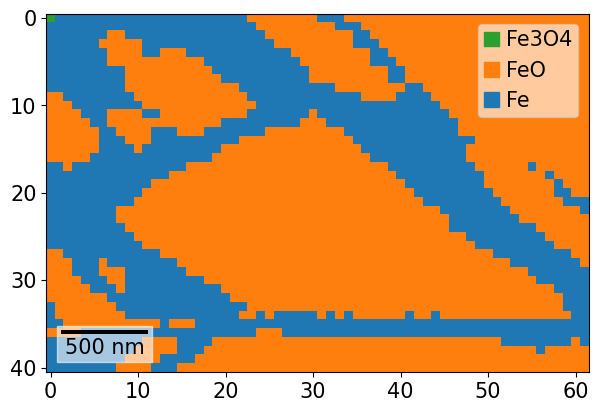

In [6]:
# phase map
xmap.plot()

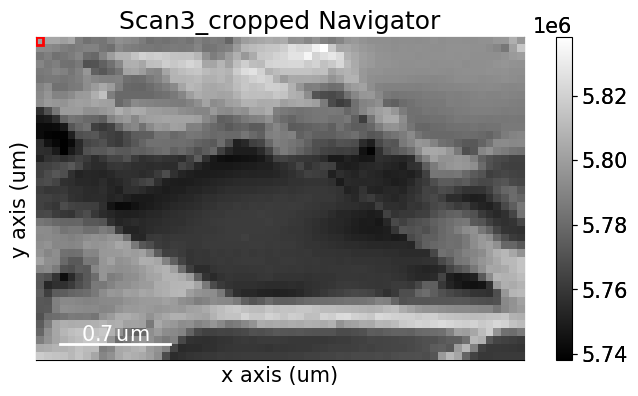

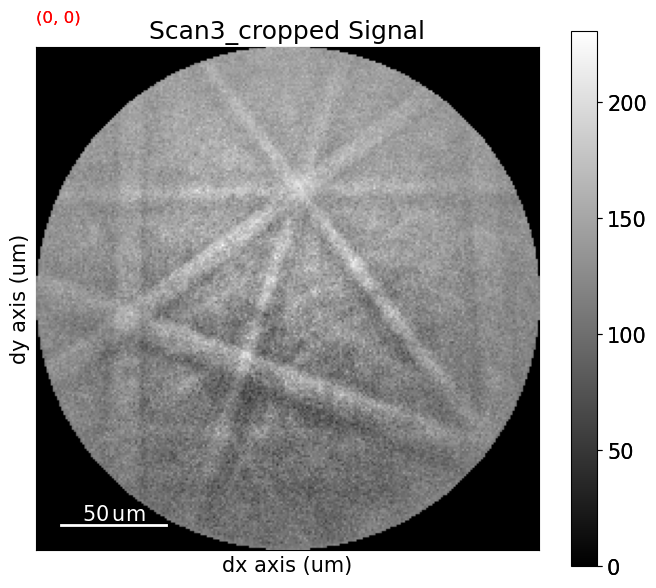

In [43]:
# Image quality map and kikuchi pattern

s_edax.plot()

In [8]:
# set the space group number
# the crystal structure of iron would be changed based on the temperature and pressure
# α-Fe (Ferrite): Body-Centered Cubic (BCC)  Im-3m  (229); γ-Fe (Austenite): Face-Centered Cubic (FCC)  Fm-3m(225); δ-Fe; ε-Fe
xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [7]:
# xmap parameters: IQ, CI, sem, fit, bs, cs, ts, oxygen, Mg, Al, Si, Ti, Mn, Fe
xmap.prop


# xmap.prop["iq"] = xmap.prop.pop("unknown1")
# xmap.prop["ci"] = xmap.prop.pop("unknown2")
# xmap.prop["sem"] = xmap.prop.pop("unknown3")
# xmap.prop["fit"] = xmap.prop.pop("unknown4")
# xmap.prop["bs"] = xmap.prop.pop("unknown5")
# xmap.prop["cs"] = xmap.prop.pop("unknown6")
# xmap.prop["ts"] = xmap.prop.pop("unknown7")
# xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
# xmap.prop["Mg"] = xmap.prop.pop("unknown9")
# xmap.prop["Al"] = xmap.prop.pop("unknown10")
# xmap.prop["Si"] = xmap.prop.pop("unknown11")
# xmap.prop["Ti"] = xmap.prop.pop("unknown12")
# xmap.prop["Mn"] = xmap.prop.pop("unknown13")
# xmap.prop["Fe"] = xmap.prop.pop("unknown14")

{'unknown1': array([0.00000000e+00, 9.64227904e+08, 9.94274304e+08, ...,
        1.26061517e+09, 1.28017229e+09, 1.28190464e+09]),
 'unknown2': array([0.   , 0.364, 0.241, ..., 0.173, 0.291, 0.291]),
 'unknown3': array([13840., 13971., 13657., ..., 11867., 12197., 12209.]),
 'unknown4': array([1.698, 1.872, 1.85 , ..., 1.528, 1.381, 1.4  ]),
 'unknown5': array([202.768204, 203.100693, 202.624207, ..., 199.769394, 199.568802,
          0.      ]),
 'unknown6': array([2267.427979, 2271.670898, 2283.7771  , ..., 2210.727051,
        2210.87793 ,    0.      ]),
 'unknown7': array([319.267609, 319.920807, 320.177887, ..., 299.134186, 299.243195,
          0.      ]),
 'unknown8': array([ 931.,  942., 1004., ..., 1071., 1041., 1022.]),
 'unknown9': array([55., 60., 51., ..., 45., 32., 49.]),
 'unknown10': array([50., 51., 58., ..., 38., 42., 35.]),
 'unknown11': array([46., 61., 56., ..., 58., 50., 52.]),
 'unknown12': array([17., 10., 27., ..., 21., 13., 16.]),
 'unknown13': array([19., 12.

In [7]:
xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

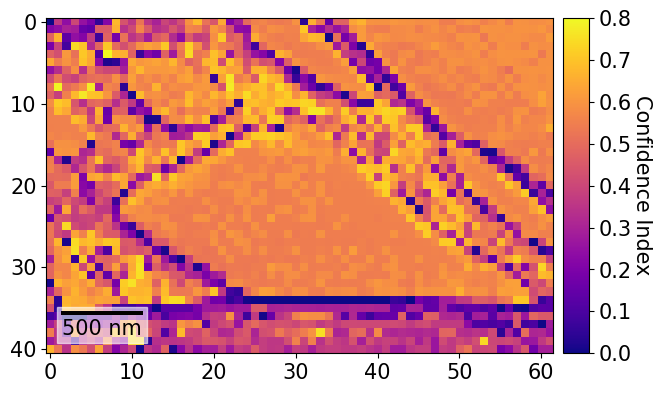

In [93]:
# Confidence index map
fig = xmap.plot(
    xmap.ci,
    cmap="plasma",
    colorbar=True,
    colorbar_label="Confidence Index",
    return_figure=True,
    )

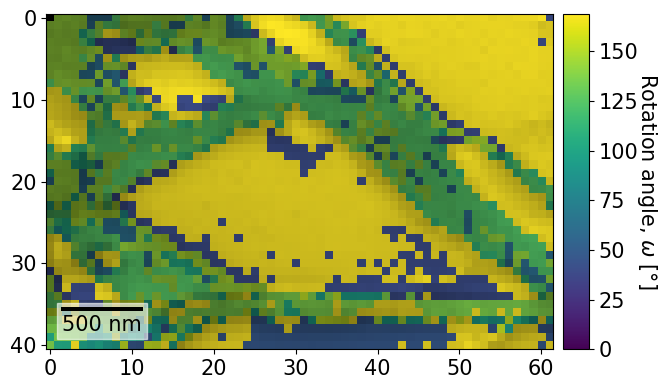

In [94]:
# Get rotation angles in degrees
angles = xmap.rotations.angle * 180 / np.pi

xmap.plot(
    angles,
    vmax=angles.max()-10,
    overlay=xmap.iq,
    colorbar=True,
    colorbar_label=r"Rotation angle, $\omega$ [$\degree$]",
)

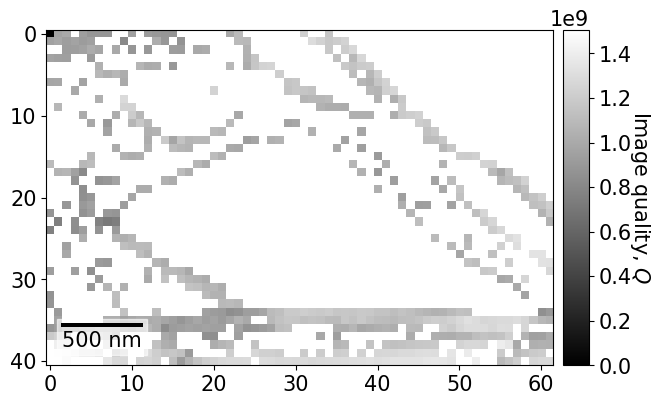

In [31]:
# Conditional slicing：plot the ci value < 0.4 -> boundary
xmap[xmap.ci < 0.4].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

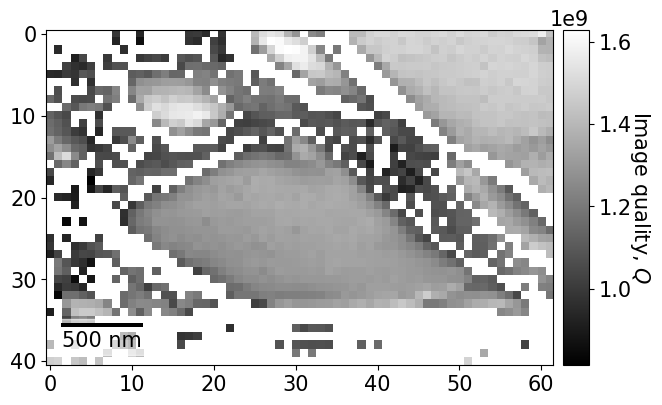

In [ ]:
xmap[xmap.ci > 0.5].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

In [11]:
print("The ci value > 0.7, x = ", xmap[xmap.ci > 0.7].x/0.05)
print("The ci value > 0.7, y = ", xmap[xmap.ci > 0.7].y/0.05)

The ci value > 0.7, x =  [31. 21.  3.  7. 14. 17.  4.  7. 17. 22. 26.  1.  5. 22. 28. 39.  4. 22.
 24. 29.  1. 28. 30. 31. 32. 40. 24. 27. 32. 33. 36. 40. 41. 42. 43. 27.
 28. 39. 41. 42. 22. 44. 45. 18. 19. 25. 26. 27. 45. 16. 19. 23. 24. 11.
 16. 42. 38. 41. 13. 15. 39. 55. 40. 41. 51. 56. 41. 47. 58.  2. 45. 46.
 48.  5. 46.  3.  7. 48. 49.  3.  4. 11. 57. 11. 60. 11.  9. 10.  9. 20.
 14. 15. 16. 57. 58. 10. 33. 10. 11. 53.]
The ci value > 0.7, y =  [ 1.  2.  3.  3.  3.  3.  4.  4.  4.  7.  7.  8.  8.  8.  8.  8.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12.
 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 16.
 16. 16. 18. 18. 19. 19. 19. 19. 20. 20. 20. 20. 21. 21. 21. 25. 25. 25.
 25. 26. 26. 27. 27. 27. 27. 28. 29. 29. 29. 30. 30. 31. 32. 32. 33. 33.
 34. 34. 34. 34. 34. 38. 38. 39. 39. 39.]


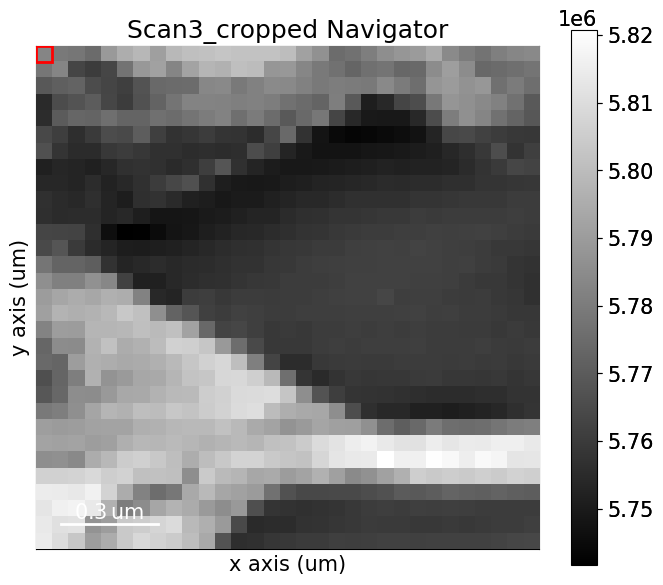

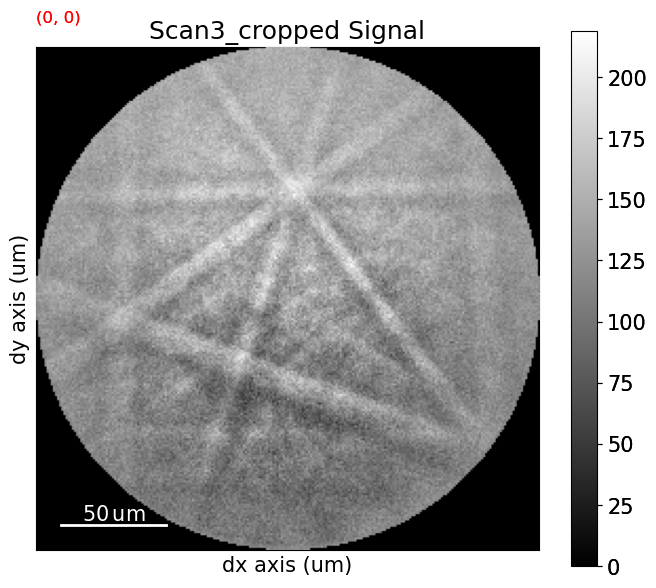

In [12]:
s_edax.inav[5:36,10:41].plot()

In [9]:
s_edax.xmap = xmap
s_edax.xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [90]:
output_dir = "EBSD_scan"
os.makedirs(output_dir, exist_ok=True)  # Create the folder if not existed

# Gain the navigation shape
n_rows, n_cols = s_edax.axes_manager.navigation_shape
print(n_rows, n_cols)
# iterate all the scan points and display the progress
for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        # Obtain the data at [i,j]
        # print(i,j)
        pattern = s_edax.inav[i, j].data

        # Preprocessing normalization?
        # pattern_normalized = (pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255
        # pattern_normalized = pattern_normalized.astype(np.uint8)

        # Define the name of output pictures
        filename = os.path.join(output_dir, f"scan3_x_{i}_y_{j}.jpg")

        # save as jpg(grey figure)
        plt.imsave(filename, pattern, cmap="gray", vmin=pattern.min(), vmax=pattern.max())

62 41


100%|██████████| 62/62 [01:00<00:00,  1.03it/s]


## 1.2 Select initial components

x dimensions 62 
 y dimensions 41 
 in multiples of 1


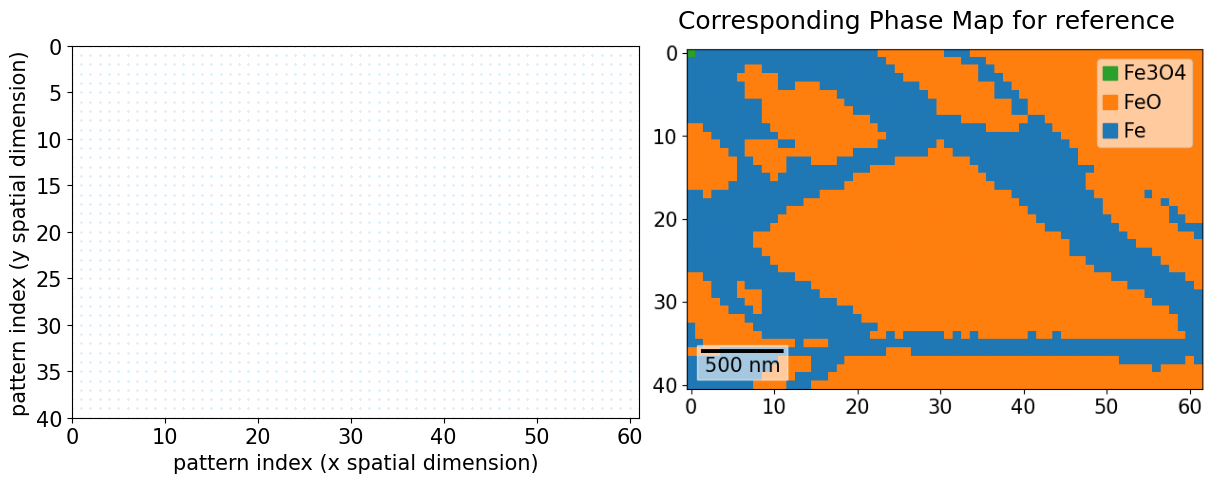

In [10]:
path = "../EBSD_scan/"
grid = read_data(path)

In [9]:
x_range_r1, y_range_r1, x_range_r2, y_range_r2= (30,35), (25,30), (40,45), (12,17)
# s_edax.inav[30:37,25:32].xmap.plot()

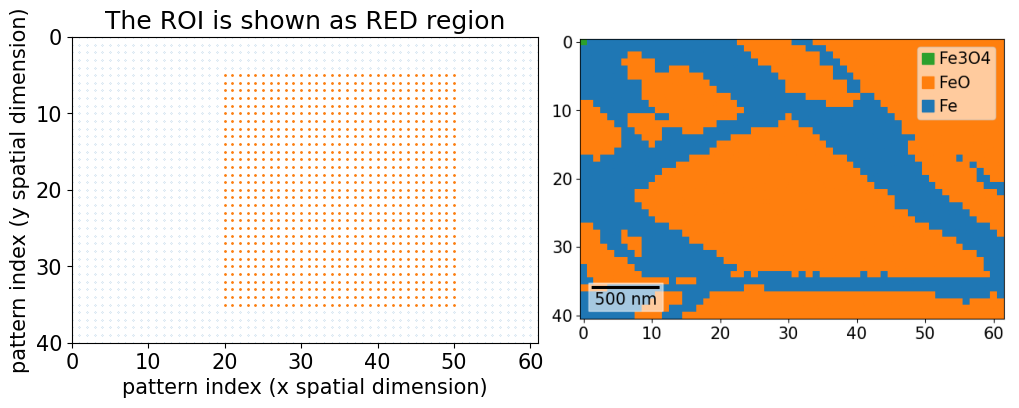

In [11]:
# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)

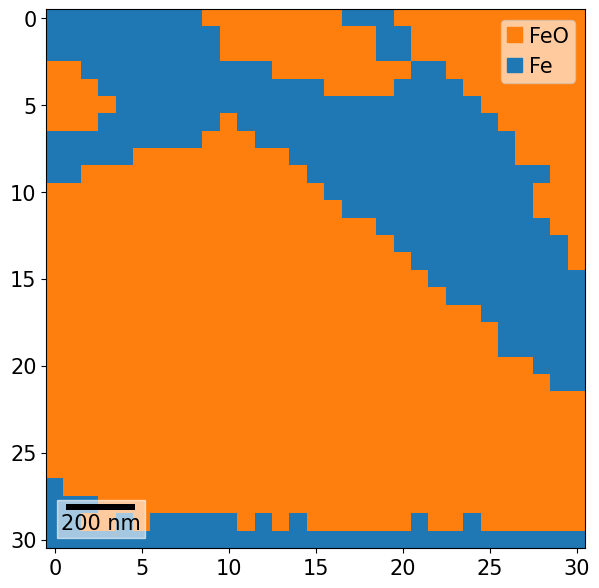

In [12]:
s_edax.inav[20:51,5:36].xmap.plot()

### 1.3 PCA

In [13]:
# dict {x,y} coordinates: phase index (all included)
coor_dict = coord_xmap_dict(s_edax.xmap,0.05)
coor_dict_roi = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)

In [17]:
# weights for each component
pca_scores, pca = run_PCA(R6, 10)

[                                        ] | 0% Completed | 870.40 us

[########################################] | 100% Completed | 110.92 ms
[########################################] | 100% Completed | 108.87 ms
[########################################] | 100% Completed | 139.04 ms
[########################################] | 100% Completed | 113.21 ms
[########################################] | 100% Completed | 110.60 ms
[########################################] | 100% Completed | 115.41 ms
[########################################] | 100% Completed | 111.01 ms
[########################################] | 100% Completed | 108.07 ms
[########################################] | 100% Completed | 106.57 ms
[########################################] | 100% Completed | 108.89 ms
[########################################] | 100% Completed | 121.77 ms
[########################################] | 100% Completed | 126.72 ms
[########################################] | 100% Completed | 107.55 ms
[########################################] | 100% Completed | 10

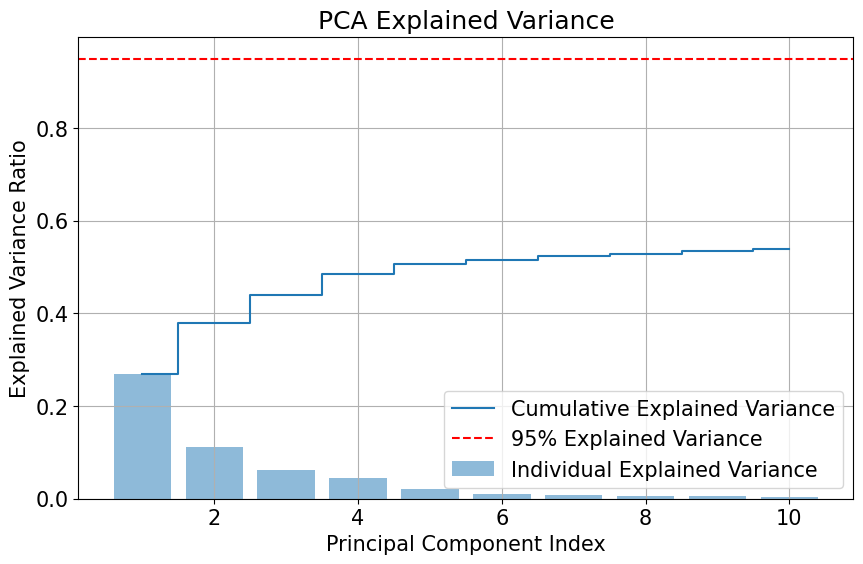

In [15]:
plot_explained_variance(pca)

- The first 8-10 PCs contribute the most variance (nearly 60%) and after the first 10 components, the cumulative curve shows each component explained little variance each.
- That could be several reasons: 
    1) High noise level; 
    2) Redundancy, very closely related features
    3) underlying nonlinear relationship between features

- Solutions:
    1) clustering
    2) Nonlinear DR(t-SNE/UMAP)


> ### GMM clustering

In [12]:
# transform the actual coordinates to the relative coordinates within ROI 
def coord_transform(loc):
    return np.array([(int(x - 20), int(y - 5)) for x, y in loc])
loc_relative = coord_transform(loc)

# transform the key and return new dictionary
def coord_dict_transform(coord_dict):
    return { (int(x-20), int(y-5)) : v for (x, y), v in coord_dict.items() }

coor_dict_roi =coord_dict_transform(coor_dict_roi)

In [20]:
loc = np.array(loc)
# gmm_model1, cluster_coords_1, cluster_labels1, optimal_n, silhouette = gmm_clustering(pca_scores, loc_relative, 3, 10)
gmm_model1, cluster_coords_1, cluster_labels1, optimal_n, silhouette = gmm_clustering(pca_scores, loc, 3, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label1 = {}
for label, coords_list in cluster_coords_1.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label1[coord_tuple] = label
#anomalies_cluster_pca_scores1, anomalies_cluster_pca_coords1, anomalies_labels_pca1 = detect_anomalies_pca(pca_scores, coord_to_label1, loc_relative)
anomalies_cluster_pca_scores1, anomalies_cluster_pca_coords1, anomalies_labels_pca1 = detect_anomalies_pca(pca_scores, coord_to_label1, loc)
centers1, covs1, variations1 = calculate_cluster_metrics(gmm_model1, cluster_labels1, pca_scores)

Optimal clustering number: 3, silhouette: 0.266


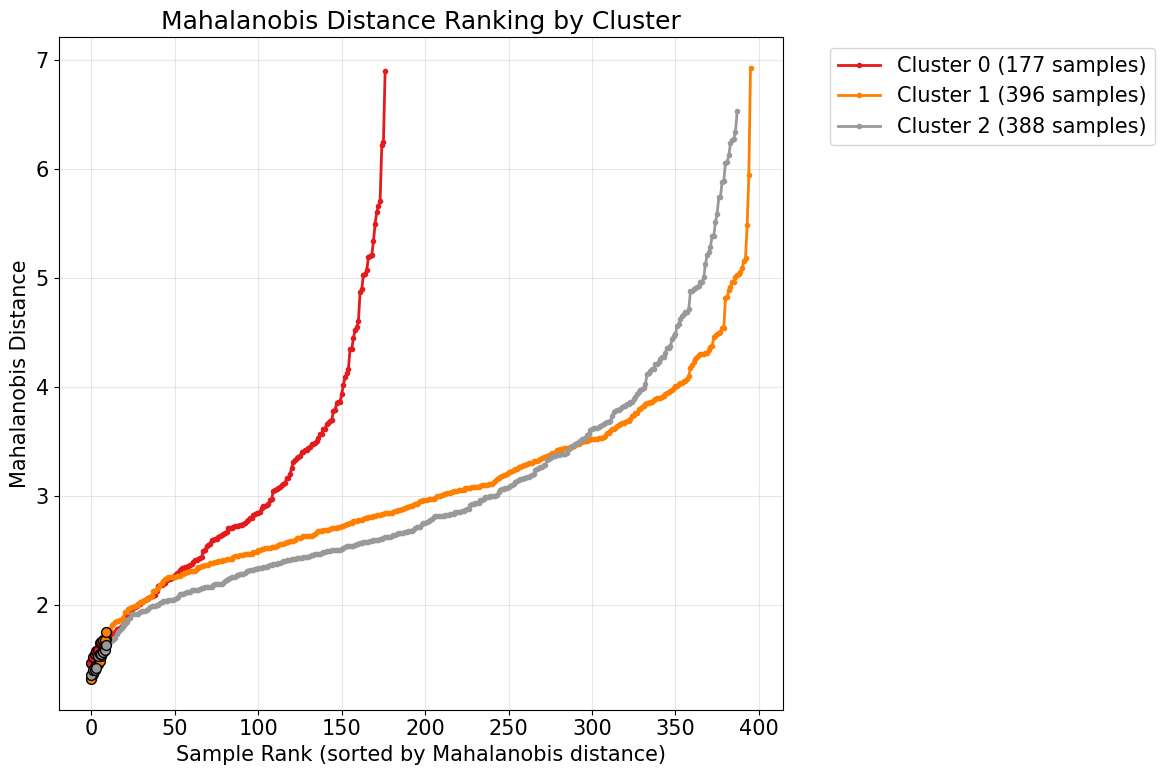

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.4716 - 1.6892
  Coordinates: [[47  6]
 [43  5]
 [48  8]]...

Cluster 1: 10 samples
  Distance range: 1.3209 - 1.7557
  Coordinates: [[41 16]
 [32 12]
 [42 16]]...

Cluster 2: 10 samples
  Distance range: 1.3606 - 1.6381
  Coordinates: [[30 27]
 [26 25]
 [24 25]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [49  6]
  Metric Value: 1.8504 (w1=1, w2=1)
  Window Mean Distance: 1.7999
  Window Variance: 0.0506
----------------------------------------
Cluster 1:
  Center Location: [42 18]
  Metric Value: 1.9250 (w1=1, w2=1)
  Window Mean Distance: 1.8609
  Window Variance: 0.0641
----------------------------------------
Cluster 2:
  Center Location: [29 28]
  Metric Value: 2.0350 (w1=1, w2=1)
  Window Mean Distance: 1.9047
  Window Variance: 0.1304
----------------------------------------


In [23]:
top_samples_per_cluster= plot_cluster_distances_ranking(gmm_model1, cluster_labels1, pca_scores, loc)
best_window = find_best_reference_window(top_samples_per_cluster, cluster_labels1, variations1, loc)

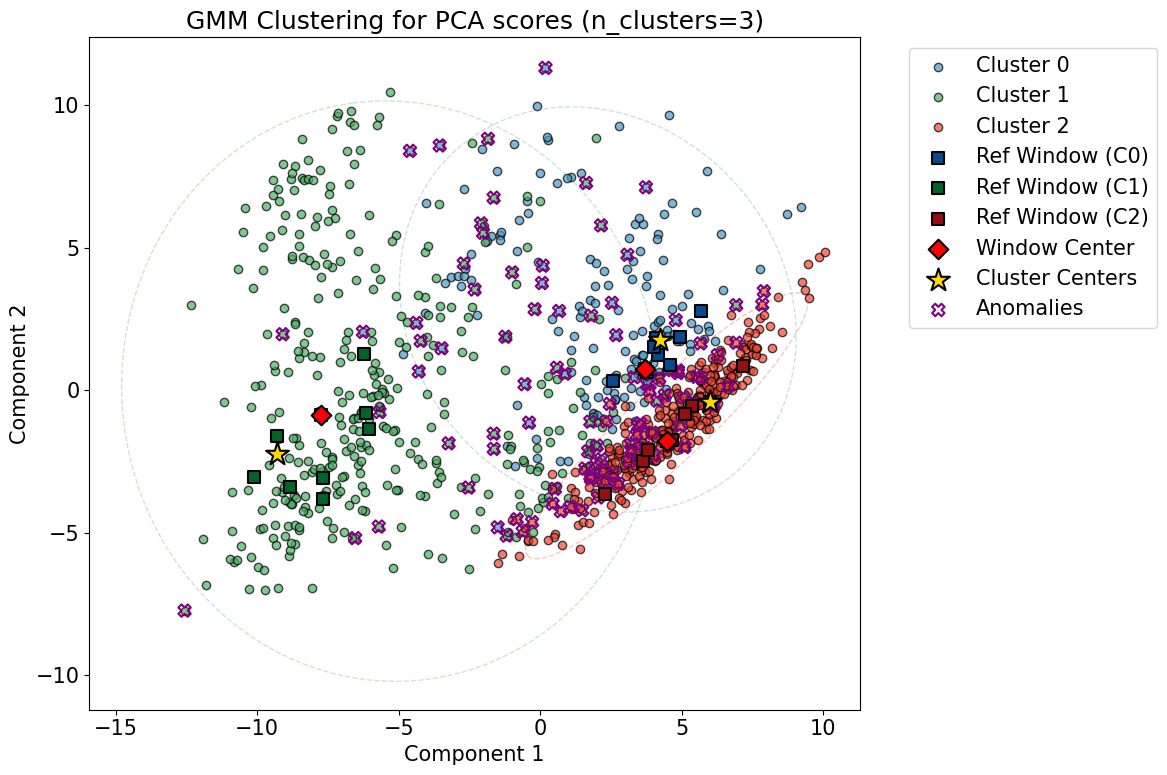

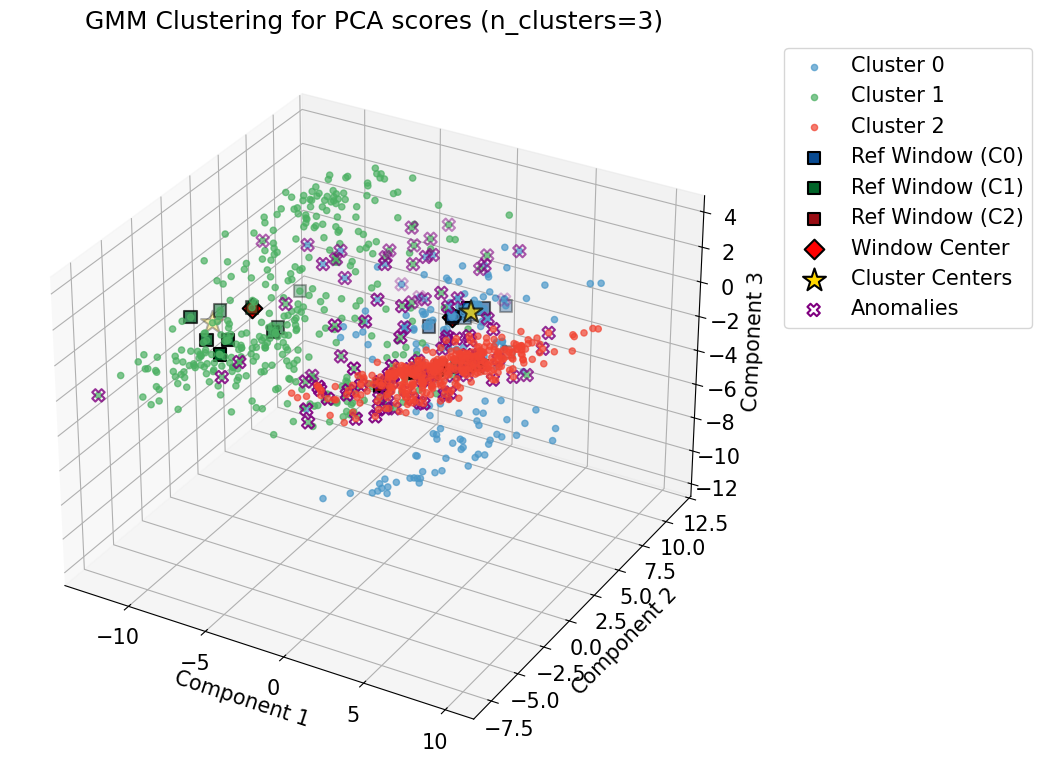

In [14]:
plot_gmm_clusters(pca_scores, cluster_labels1, optimal_n, variations1, 2, anomalies_cluster_pca_scores1, best_window)
plot_gmm_clusters(pca_scores, cluster_labels1, optimal_n, variations1, 3, anomalies_cluster_pca_scores1, best_window)

Optimal clustering number: 2, silhouette: 0.317


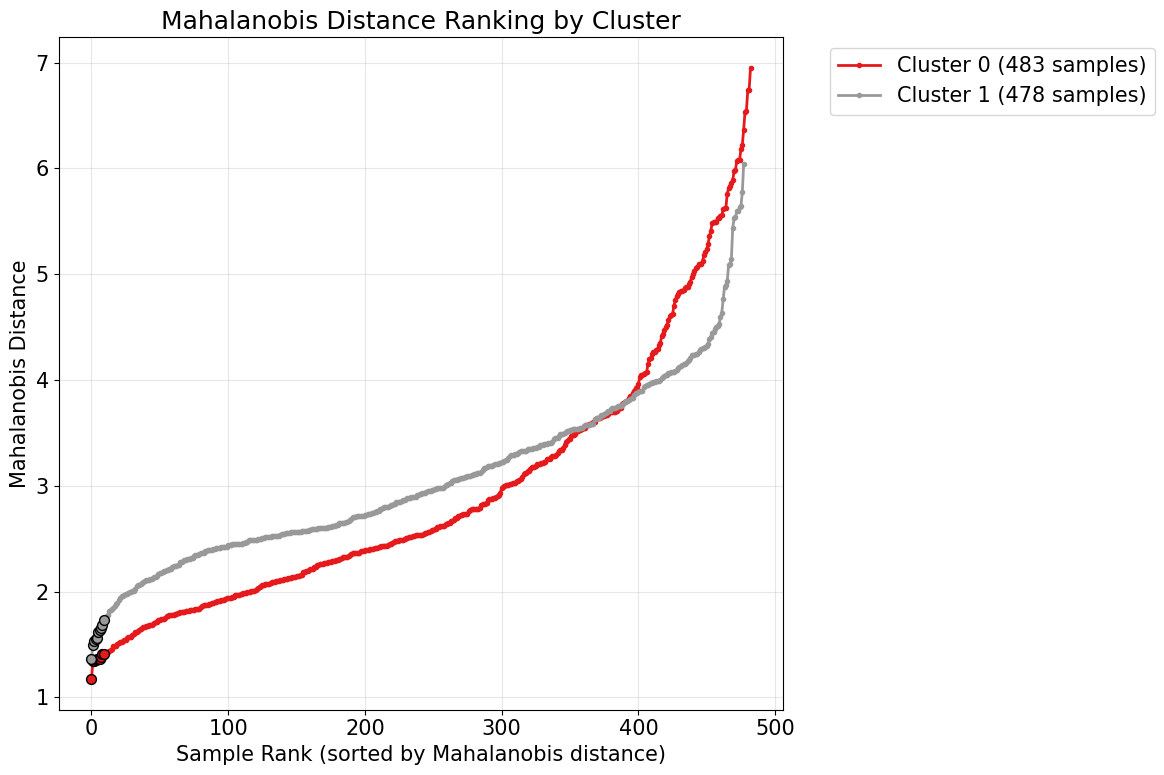

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 1.1717 - 1.4073
  Coordinates: [[29 27]
 [33 25]
 [24 25]]...

Cluster 1: 10 samples
  Distance range: 1.3618 - 1.7285
  Coordinates: [[32 12]
 [41 16]
 [48 16]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [29 27]
  Metric Value: 1.7666 (w1=1, w2=1)
  Window Mean Distance: 1.6862
  Window Variance: 0.0804
----------------------------------------
Cluster 1:
  Center Location: [41 16]
  Metric Value: 1.9042 (w1=1, w2=1)
  Window Mean Distance: 1.8374
  Window Variance: 0.0667
----------------------------------------


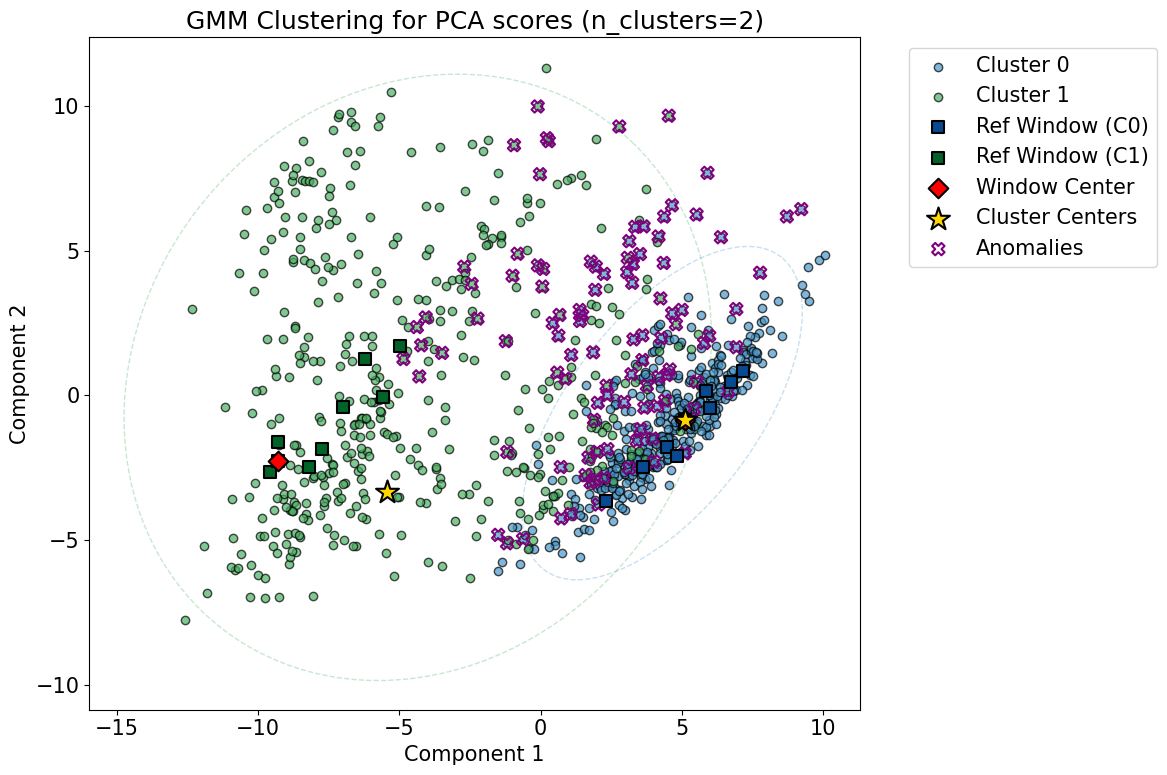

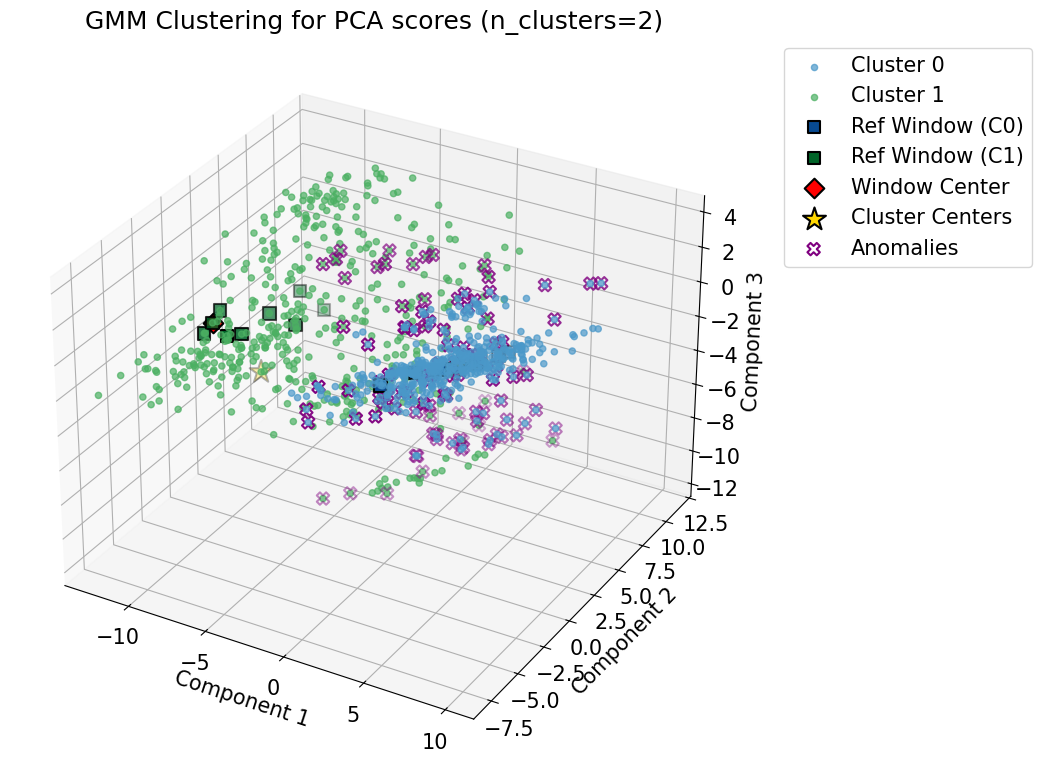

In [21]:
gmm_model2, cluster_coords_c2, cluster_labels2, optimal_n, silhouette = gmm_clustering(pca_scores,loc, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label2 = {}
for label, coords_list in cluster_coords_c2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label2[coord_tuple] = label
anomalies_cluster_pca_scores2, anomalies_cluster_pca_coords2, anomalies_labels_pca2 = detect_anomalies_pca(pca_scores, coord_to_label2, loc)

anomalies_coord_label_dict2 = {}
for i in range(len(anomalies_labels_pca2)):
    coord = tuple(anomalies_cluster_pca_coords2[i])
    anomalies_coord_label_dict2[coord] = anomalies_labels_pca2[i]
    
centers2, covs2, variations2 = calculate_cluster_metrics(gmm_model2, cluster_labels2, pca_scores)

top_samples_per_cluster2= plot_cluster_distances_ranking(gmm_model2, cluster_labels2, pca_scores, loc)
best_window2 = find_best_reference_window(top_samples_per_cluster2, cluster_labels2, variations2, loc)
# print(best_window2)
plot_gmm_clusters(pca_scores, cluster_labels2, optimal_n, variations2, 2, anomalies_cluster_pca_scores2, best_window2)
plot_gmm_clusters(pca_scores, cluster_labels2, optimal_n, variations2, 3, anomalies_cluster_pca_scores2, best_window2)


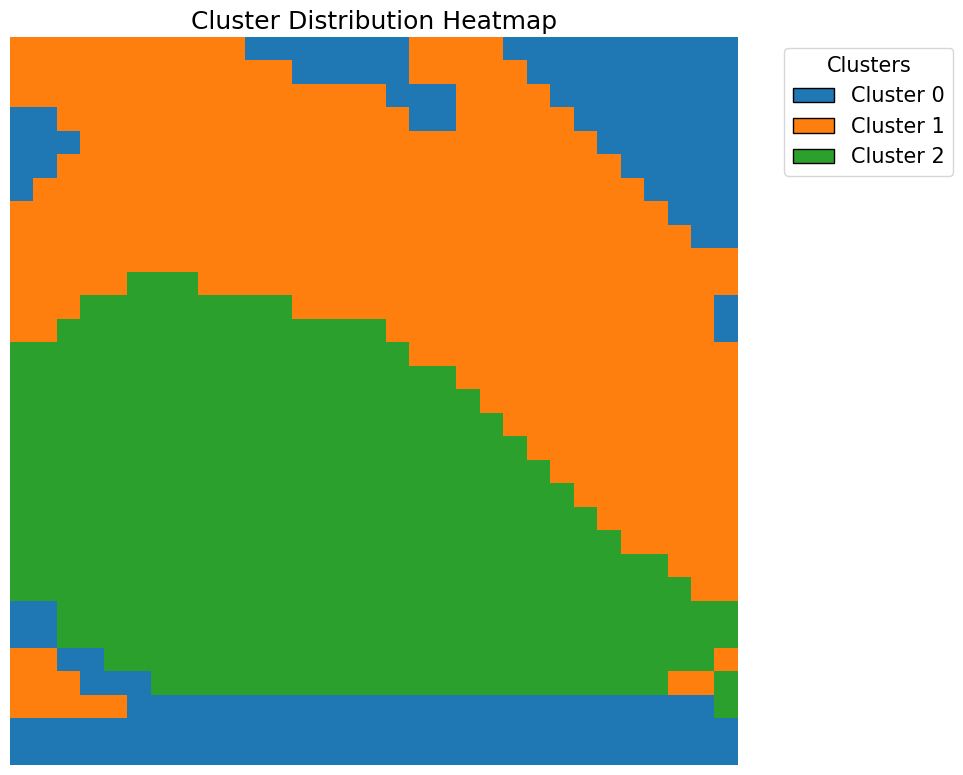

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.268867
             NMI 0.308973
     homogeneity 0.412703
    completeness 0.246913
       v_measure 0.308973
   user_accuracy 0.827806
optimal_accuracy 0.411030

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      177      Unknown               FeO
       1      396           Fe                Fe
       2      388          FeO          Unmapped

Confusion Matrix (After Mapping):
------------------------------------------------------------
                Pred: Phase_-1  Pred: FeO  Pred: Fe
True: Phase_-1               0          0         0
True: FeO                  388        134       135
True: Fe                     0         43       261


In [17]:
plot_cluster_heatmap(cluster_coords_1,(31,31))
cluster_name_map = {
    0: 'Unknown',
    1: 'Fe',
    2: 'FeO'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict_roi, coord_to_label1, name_map, cluster_name_map, True)

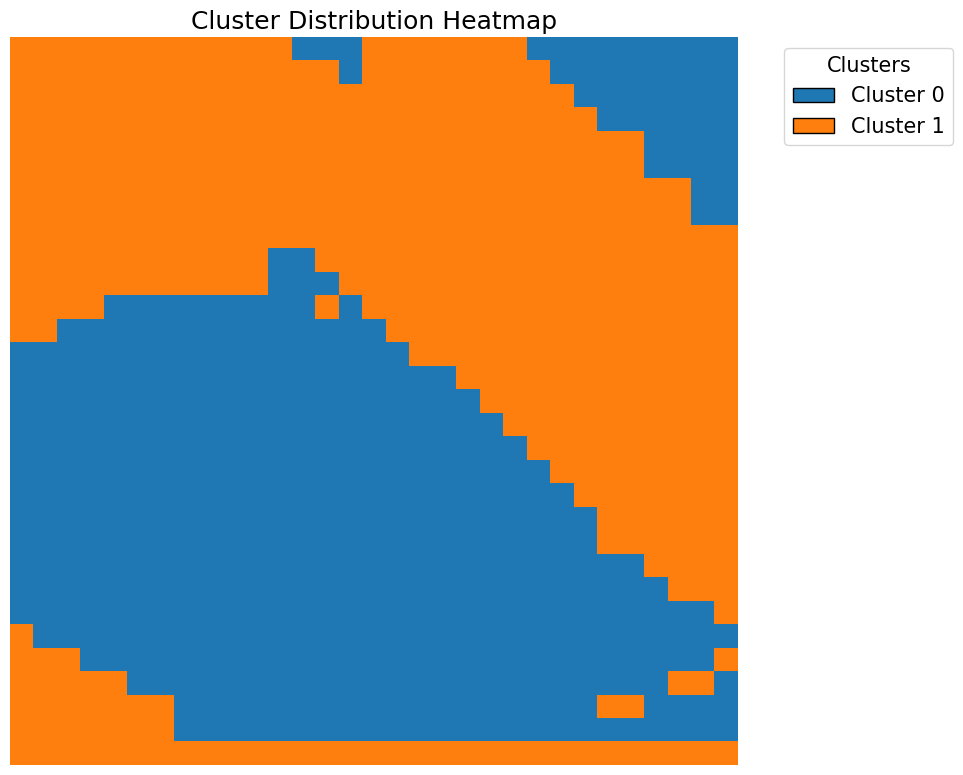

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.364941
             NMI 0.381410
     homogeneity 0.402513
    completeness 0.362411
       v_measure 0.381410
   user_accuracy 0.802289
optimal_accuracy 0.802289

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      483          FeO               FeO
       1      478           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        475       182
True: Fe           8       296


In [18]:
plot_cluster_heatmap(cluster_coords_c2,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict_roi, coord_to_label2, name_map, cluster_name_map, True)


Cluster centers and corresponding labels: [(47, 6, 0), (41, 16, 1), (30, 27, 2)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:620: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


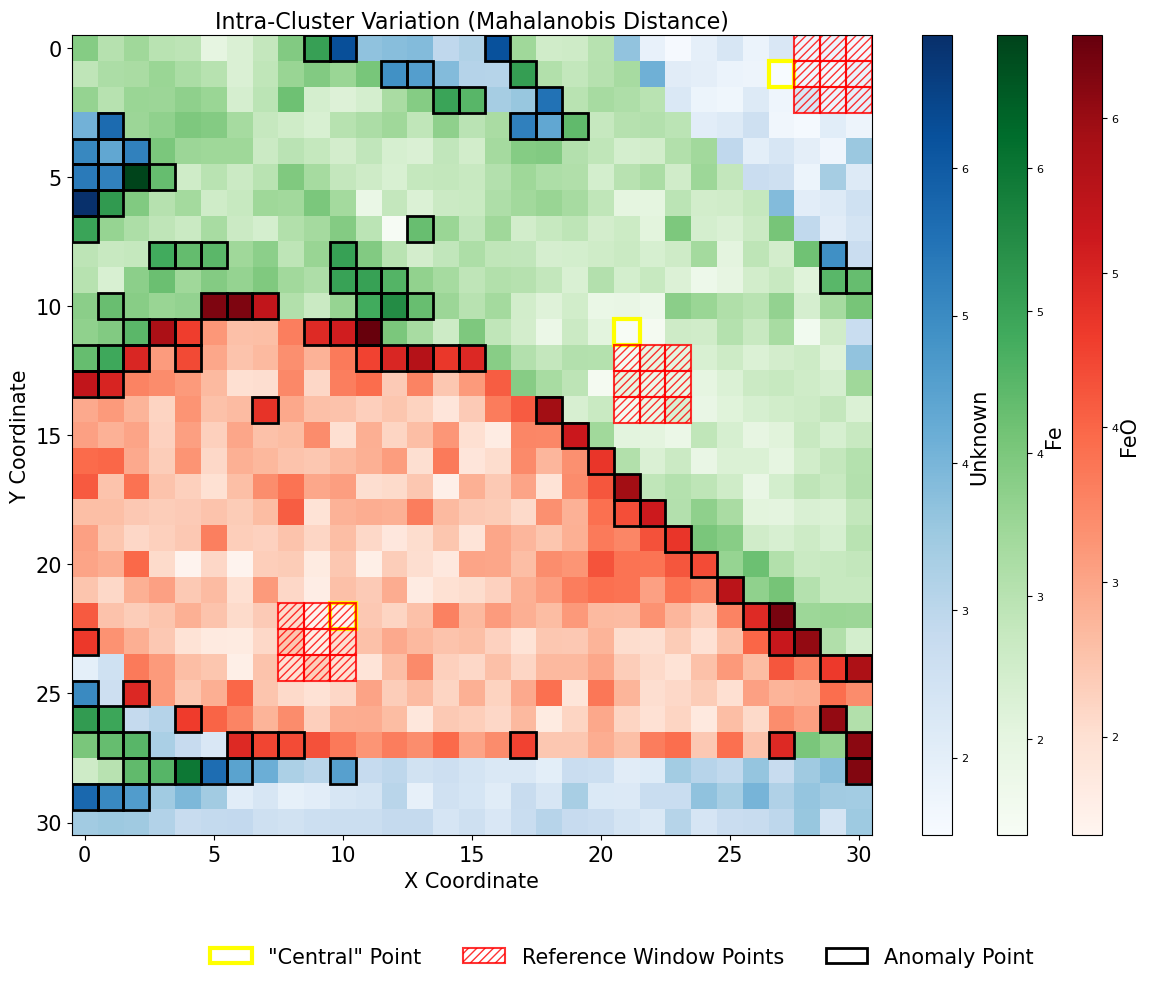

In [24]:
cluster_name_map = {
    0: "Unknown",
    1: "Fe",
    2: "FeO"
}

plot_intra_cluster_variation_map(loc, variations1, cluster_labels1, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords1, None, None, best_window)

Cluster centers and corresponding labels: [(29, 27, 0), (32, 12, 1)]


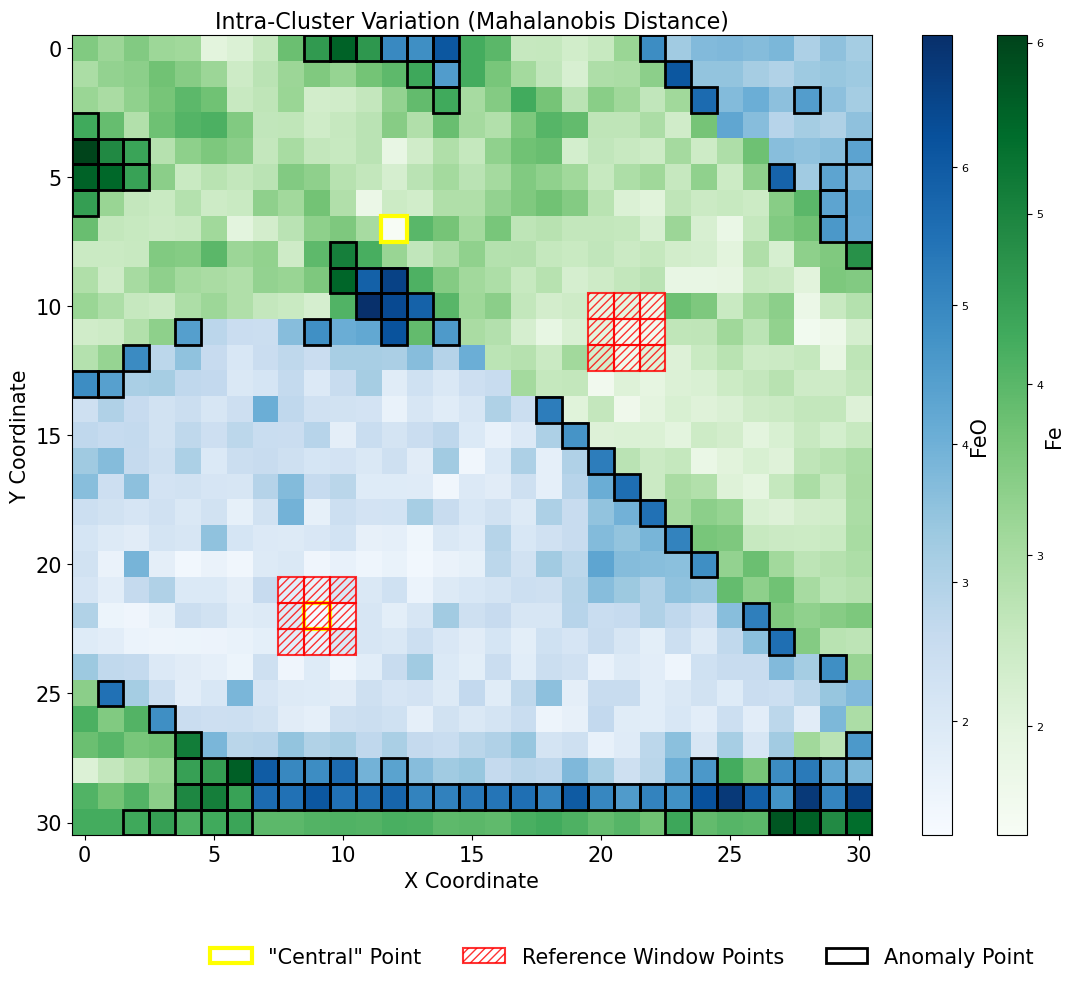

In [20]:
cluster_name_map = {
    0: "FeO",
    1: "Fe"
}

plot_intra_cluster_variation_map(loc, variations2, cluster_labels2, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords2,None,None, best_window2)

### Clustering Results and Reference Window Selection

- **Optimal cluster number**:  
  Based on silhouette score, the optimal number of clusters is **2**. However, the silhouette score is not quite high, possibly due to sparse data or noise.

- **Clustering accuracy**:  
### 1. Evaluation Metrics

| Metric        | Value     | Description |
|---------------|-----------|-------------|
| **ARI**       | 0.364941  | Adjusted Rand Index: Measures similarity between clustering and true labels |
| **NMI**       | 0.381410  | Normalized Mutual Information: Measures shared information between clusterings |
| **Homogeneity** | 0.402513 | How pure each cluster is (only one class per cluster) |
| **Completeness** | 0.362411 | How complete class assignments are (all class members in same cluster) |
| **V-measure** | 0.381410  | Harmonic mean of homogeneity and completeness |
| **User Accuracy** | 0.802289 | Accuracy using user-defined mapping |
| **Optimal Accuracy** | 0.802289 | Accuracy using Hungarian algorithm mapping |

**Key Observations**:
- ARI and NMI values (0.36-0.38) indicate moderate agreement between clustering and true labels
- Homogeneity (0.40) is higher than completeness (0.36), suggesting clusters are purer than they are complete
- User-defined and optimal mappings yield identical accuracy (80.23%), indicating consistent performance

### 2. Optimal Cluster-to-Phase Mapping

| Cluster | Samples | User Mapping | Algorithm Mapping |
|---------|---------|--------------|-------------------|
| 0       | 483     | FeO          | FeO               |
| 1       | 478     | Fe           | Fe                |

**Analysis**:
1. Balanced cluster sizes: 483 vs 478 samples
2. Perfect mapping agreement: Both methods produce identical mappings
3. Complete coverage: All samples mapped to known phases (FeO and Fe)

### 3. Confusion Matrix (After Mapping)

| True Label \ Predicted Label | FeO | Fe |
|-----------------------------|-----|----|
| **FeO**                     | 475 | 182 |
| **Fe**                      | 8   | 296 |

**Performance Breakdown**:

**FeO Classification**:
- Correctly classified: 475 samples
- Misclassified as Fe: 182 samples
- Recall: 475/(475+182) = 72.3%

**Fe Classification**:
- Correctly classified: 296 samples
- Misclassified as FeO: 8 samples
- Recall: 296/(296+8) = 97.4%

**Overall Performance**:
- Total samples: 475 + 182 + 8 + 296 = 961
- Overall accuracy: (475 + 296)/961 = 80.23%
- Primary error source: FeO misclassified as Fe (182 samples)

**Diagnosis**:
1. Fe identification is excellent (97.4% recall)
2. FeO identification has significant challenges (27.7% error rate)
3. Potential issues:
   - Feature overlap between FeO and Fe in some regions
   - Insufficient discriminative features for FeO
   - Higher variability in FeO samples
- **Reference window strategy**:  
  For the GMM clustering results, the best reference window for each cluster is determined by:
    - Selecting the top points with the smallest Mahalanobis distances as candidates.
    - For each candidate, calculating the mean and variance of Mahalanobis distances in the surrounding 3×3 window.
    - Selecting the window with the lowest combined metric (`metric = w1 * mean + w2 * variance`, with `w1=1, w2=1`).

---

### Best Reference Windows per Cluster

#### Cluster 0
- **Center Location:** `[9, 22]`
- **Metric Value:** `1.7665`  (`w1=1, w2=1`)
- **Window Mean Distance:** `1.6862`
- **Window Variance:** `0.0803`

---

#### Cluster 1
- **Center Location:** `[21, 11]`
- **Metric Value:** `1.9042`  (`w1=1, w2=1`)
- **Window Mean Distance:** `1.8374`
- **Window Variance:** `0.0667`

> ### visualization with the prior indexing 
1. anomalies are regarded to fall out of the 95% confidence interval (assume the data follow the multivariate normal distribution)

In [16]:
# weights for each component
# pca_scores, pca = run_PCA(R6, 2)
# obtain the anomalies
pca_scores_p = pca_scores[:, :2]
anomalies_scores, anomalies_coords = detect_anomalies_pca(pca_scores,coor_dict,loc)

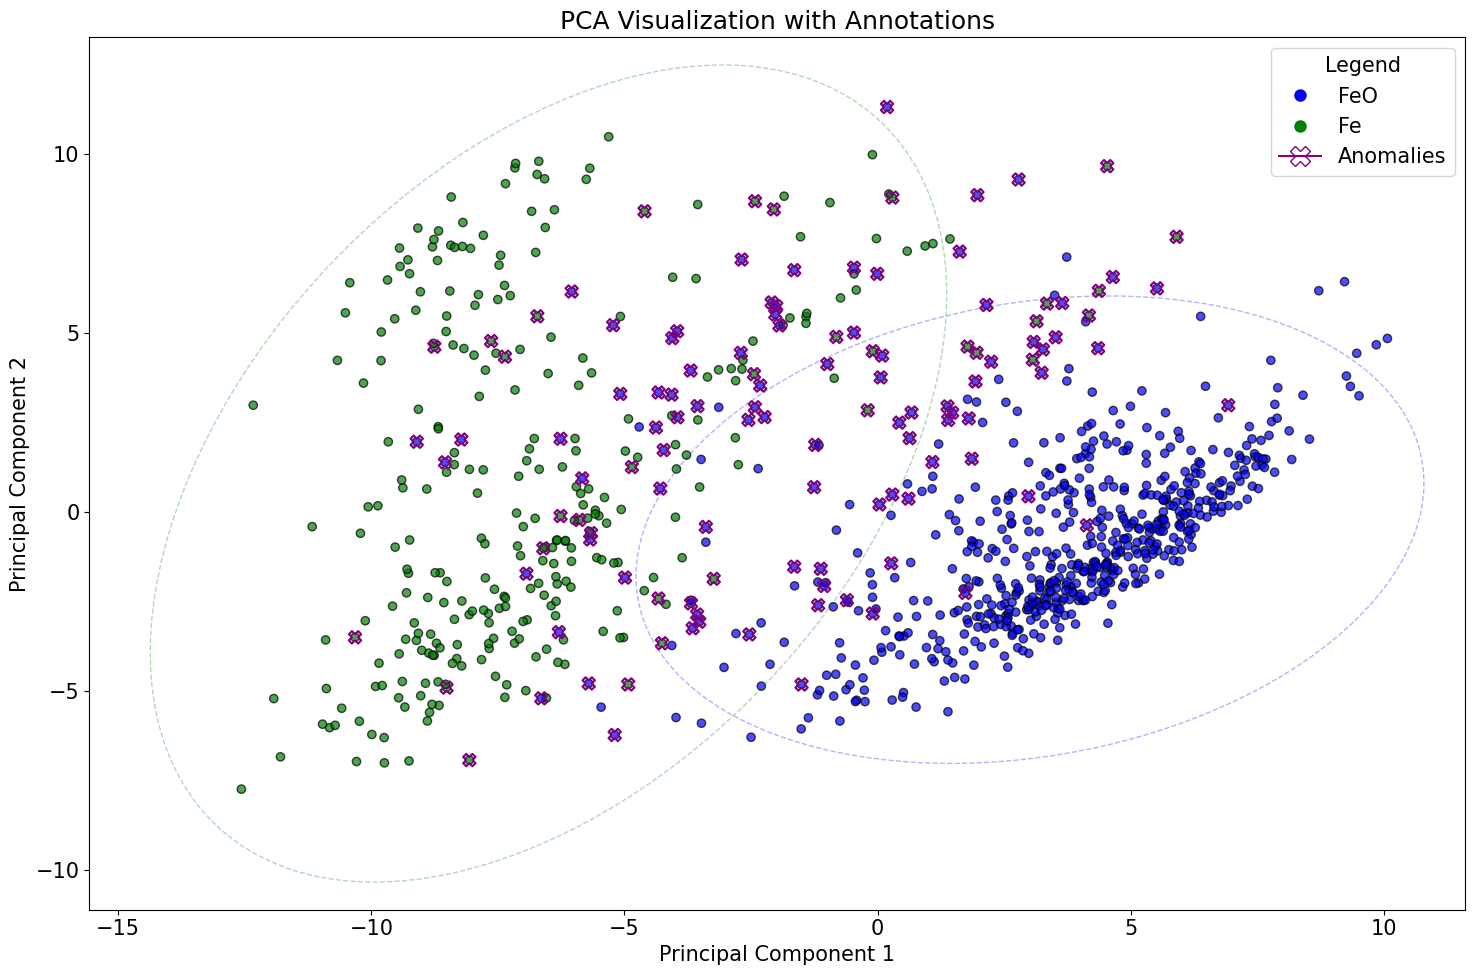

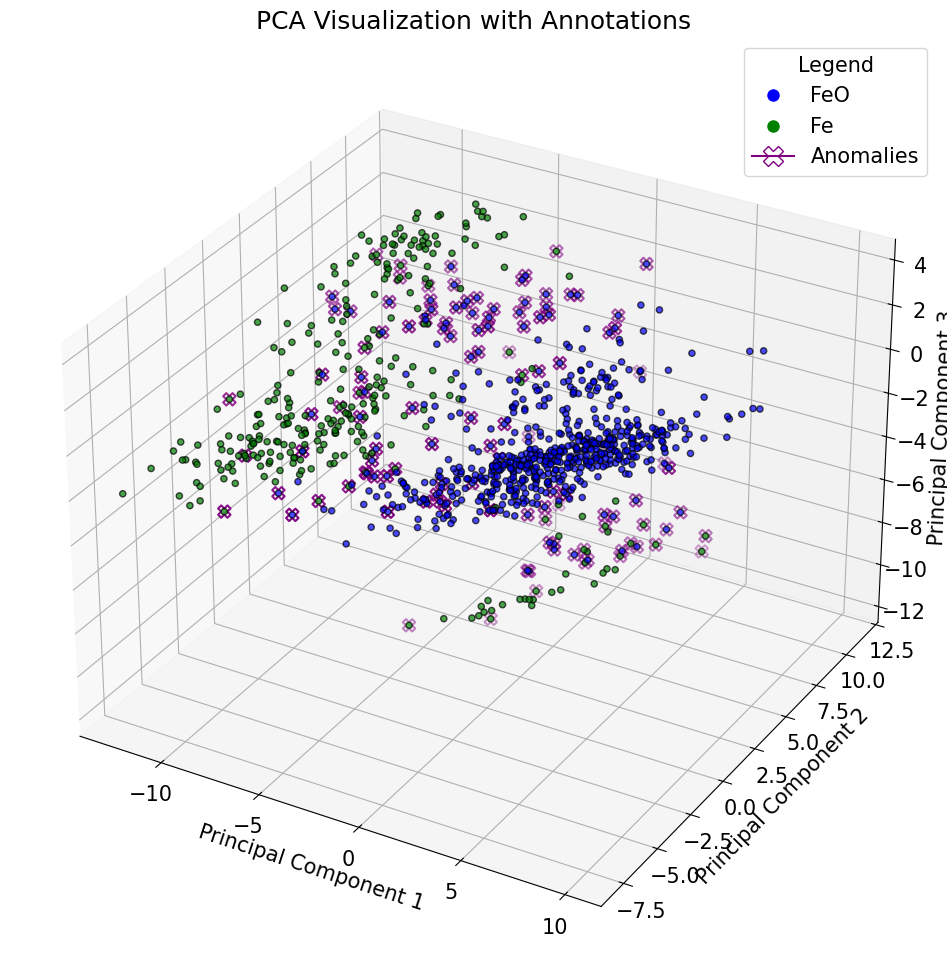

In [26]:
# plot pca weight for points within roi
# _plot_pca(pca_scores, coor_dict, loc)
_plot_pca(pca_scores, coor_dict, loc, 2, None, None, anomalies_scores, ellipse_alpha=0.3)
_plot_pca(pca_scores, coor_dict, loc, 3, None, None, anomalies_scores, ellipse_alpha=0.3)

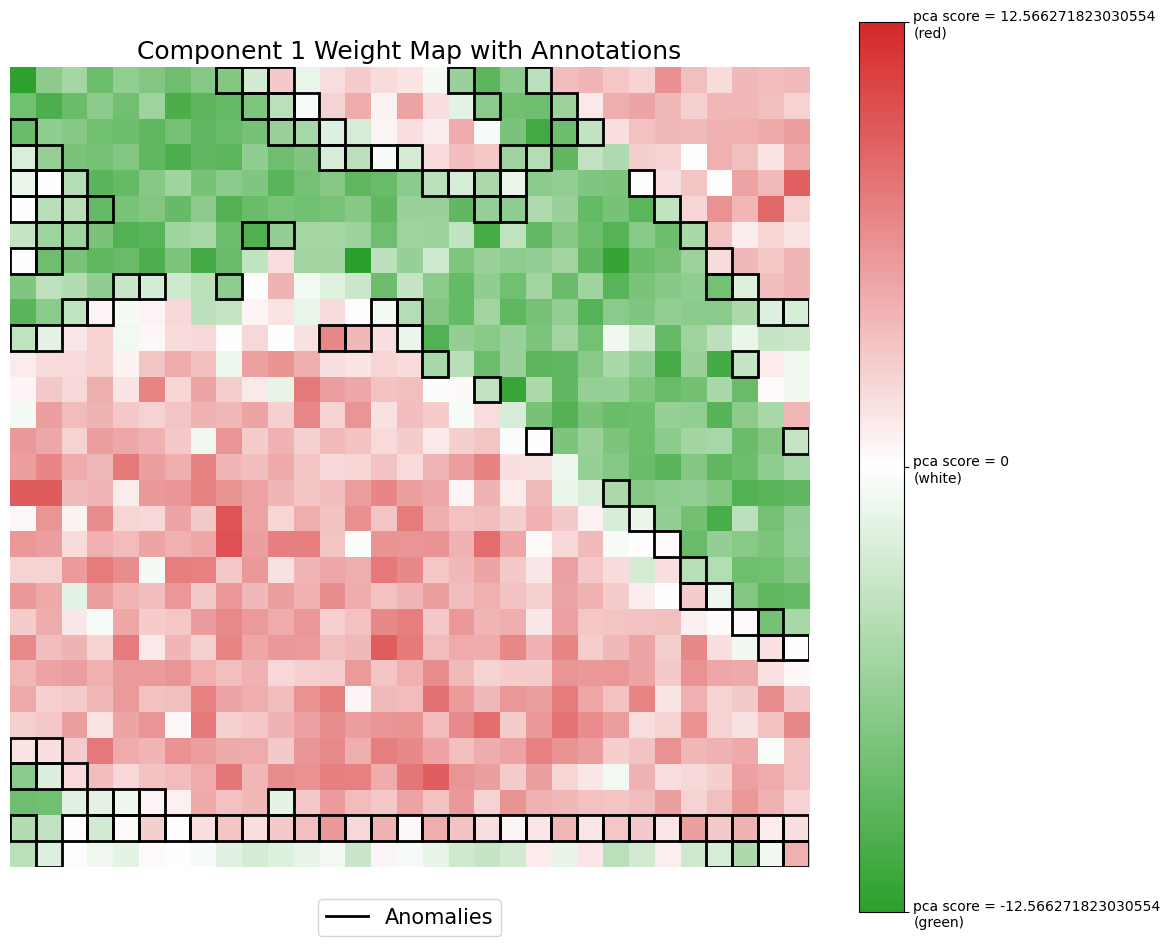

In [28]:
plot_weight_map_pca(pca_scores_p,loc,anomalies_coords,None,None,0)
# plot_weight_map_pca(pca_scores_p,loc,anomalies_coords,None,None,1)

### 1.4 cNMF

### 1.4.1 Reference components based on PCA clustering

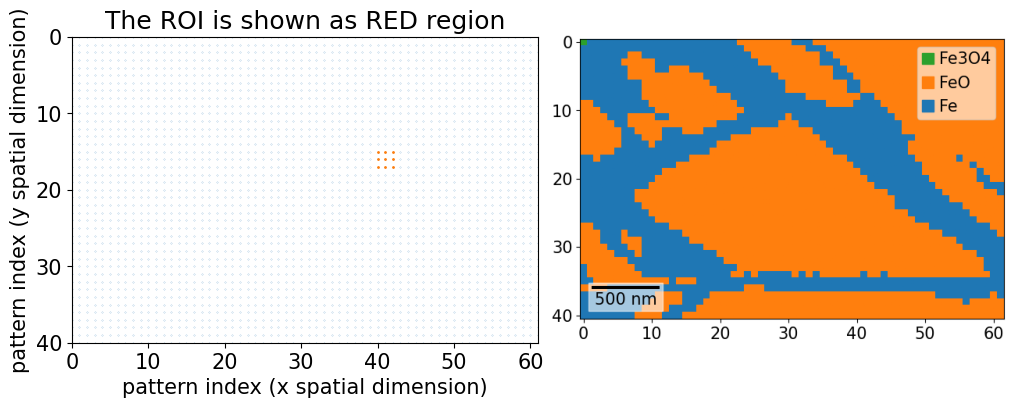

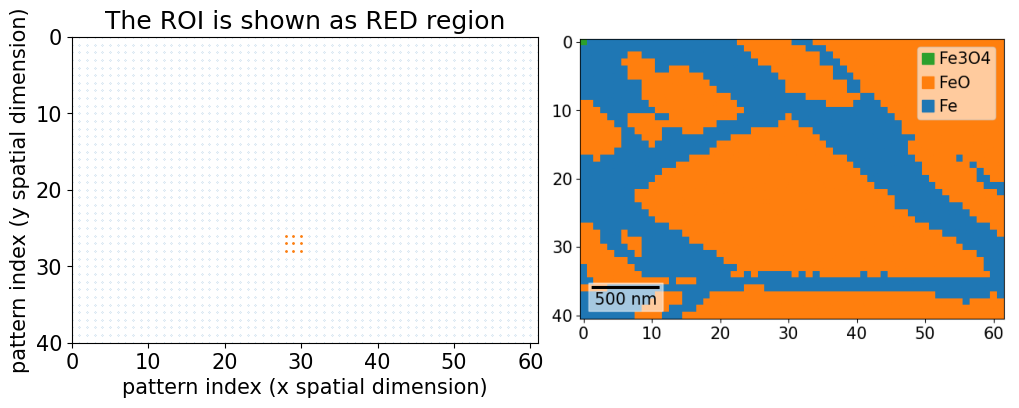

In [14]:
# set components
x_range_7 = (40,42)
y_range_7 = (15,17)
R7, ref7_pos = set_component(x_range_7, y_range_7, path, grid)


x_range_8 = (28,30)
y_range_8 = (26,28)
R8, ref8_pos = set_component(x_range_8, y_range_8, path, grid)

In [26]:
components = get_components(R7, R8)

# run cNMF
weights,mse,r_square = run_cNMF(R6, components)

gmm_model8, cluster_coords_cnmf8, cluster_labels_cnmf8, optimal_n, silhouette = gmm_clustering(weights, loc, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label_cnmf8 = {}
for label, coords_list in cluster_coords_cnmf8.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf8[coord_tuple] = label
# anomalies_cluster_cnmf_weights8, anomalies_cluster_cnmf_coords8 = detect_anomalies_cnmf(weights, coord_to_label_cnmf8, loc_relative)
# centers_c8, covs_c8, variations_c8 = calculate_cluster_metrics(gmm_model8, cluster_labels_cnmf8, weights)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 1.10 ms

[########################################] | 100% Completed | 108.67 ms
[########################################] | 100% Completed | 110.06 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 109.42 ms
[########################################] | 100% Completed | 107.50 ms
[########################################] | 100% Completed | 115.90 ms
[########################################] | 100% Completed | 110.20 ms
[########################################] | 100% Completed | 105.60 ms
[########################################] | 100% Completed | 107.32 ms
[########################################] | 100% Completed | 107.96 ms
[########################################] | 100% Completed | 106.15 ms
[########################################] | 100% Completed | 107.13 ms
[########################################] | 100% Completed | 111.25 ms
[########################################] | 100% Completed | 108.20 ms
[#########################

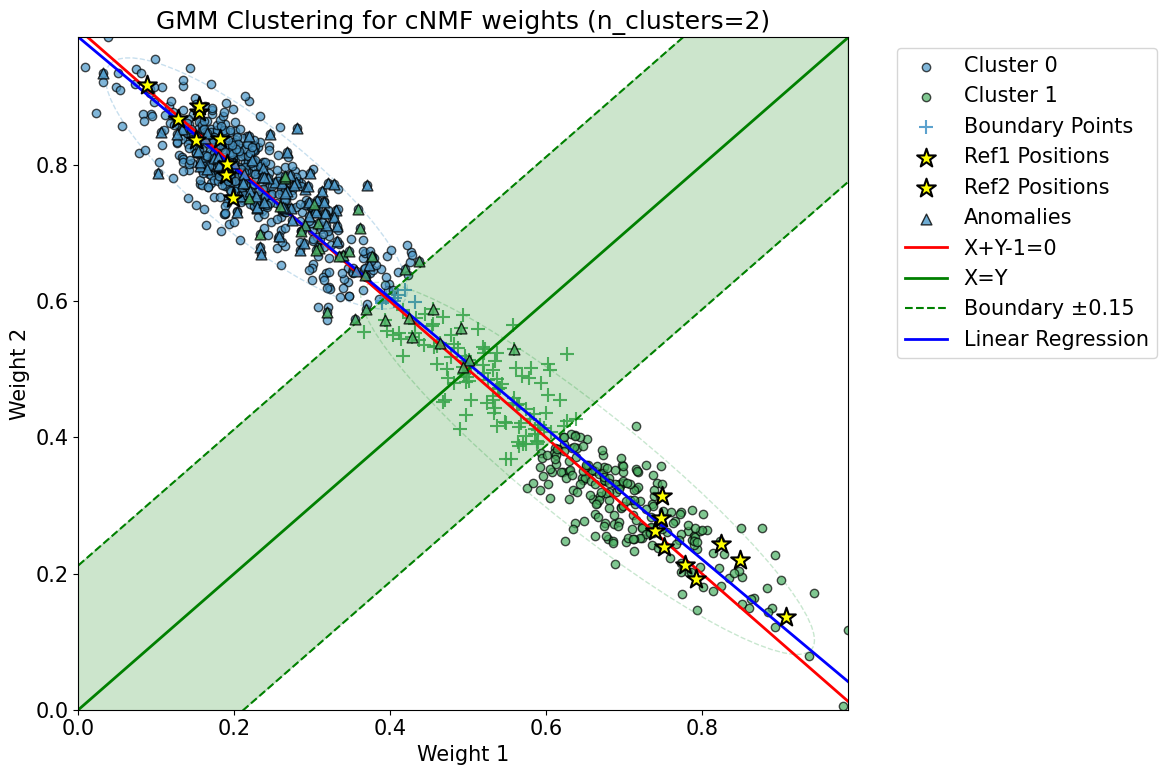

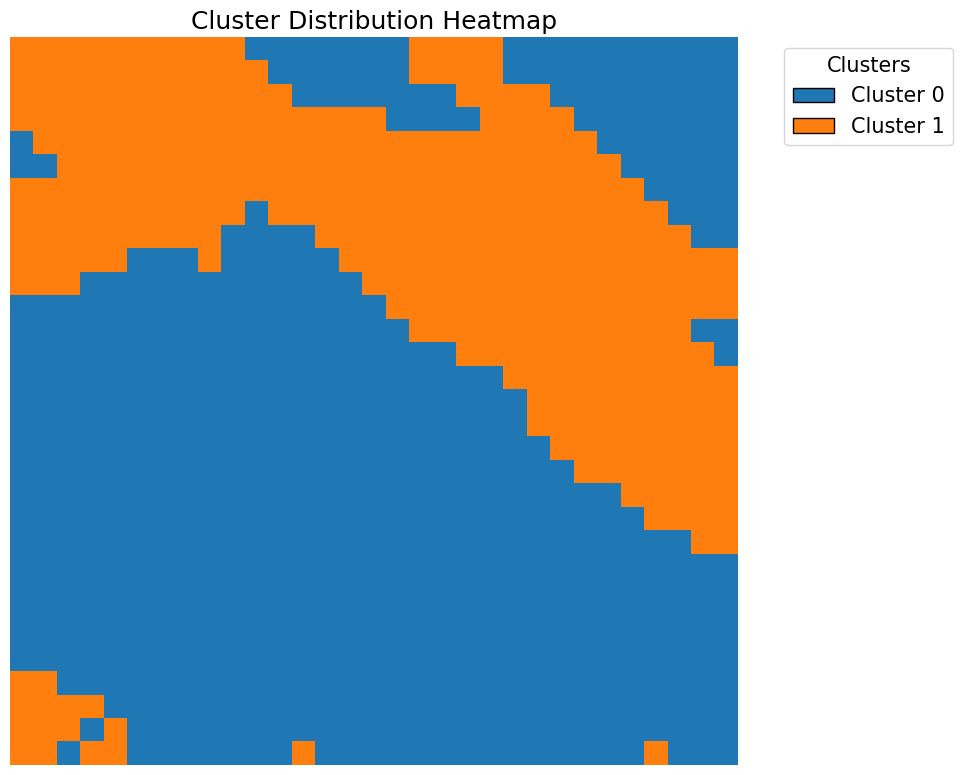

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.602676
             NMI 0.476626
     homogeneity 0.486911
    completeness 0.466767
       v_measure 0.476626
   user_accuracy 0.889698
optimal_accuracy 0.889698

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      619          FeO               FeO
       1      342           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        585        72
True: Fe          34       270


In [29]:
boundary_mask, boundary_scores, boundary_locs, boundary_labels, slope, intercept = plot_cnmf_scatter_with_boundary(weights, loc, cluster_labels_cnmf8, optimal_n, ref7_pos, ref8_pos, anomalies_coord_label_dict2, d=0.15)

plot_cluster_heatmap(cluster_coords_cnmf8,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict_roi, coord_to_label_cnmf8, name_map, cluster_name_map, True)

> * Scatter plotting with prior indexing and weight map

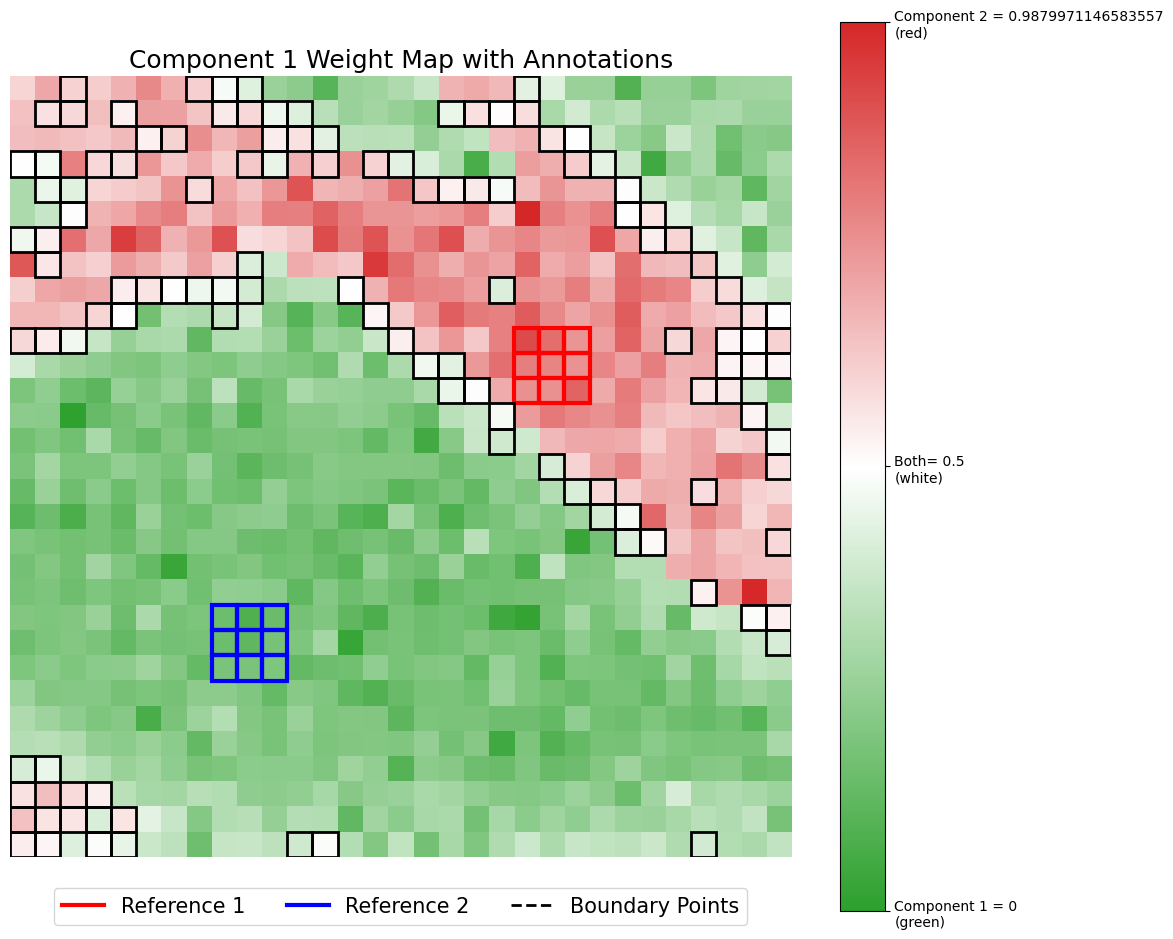

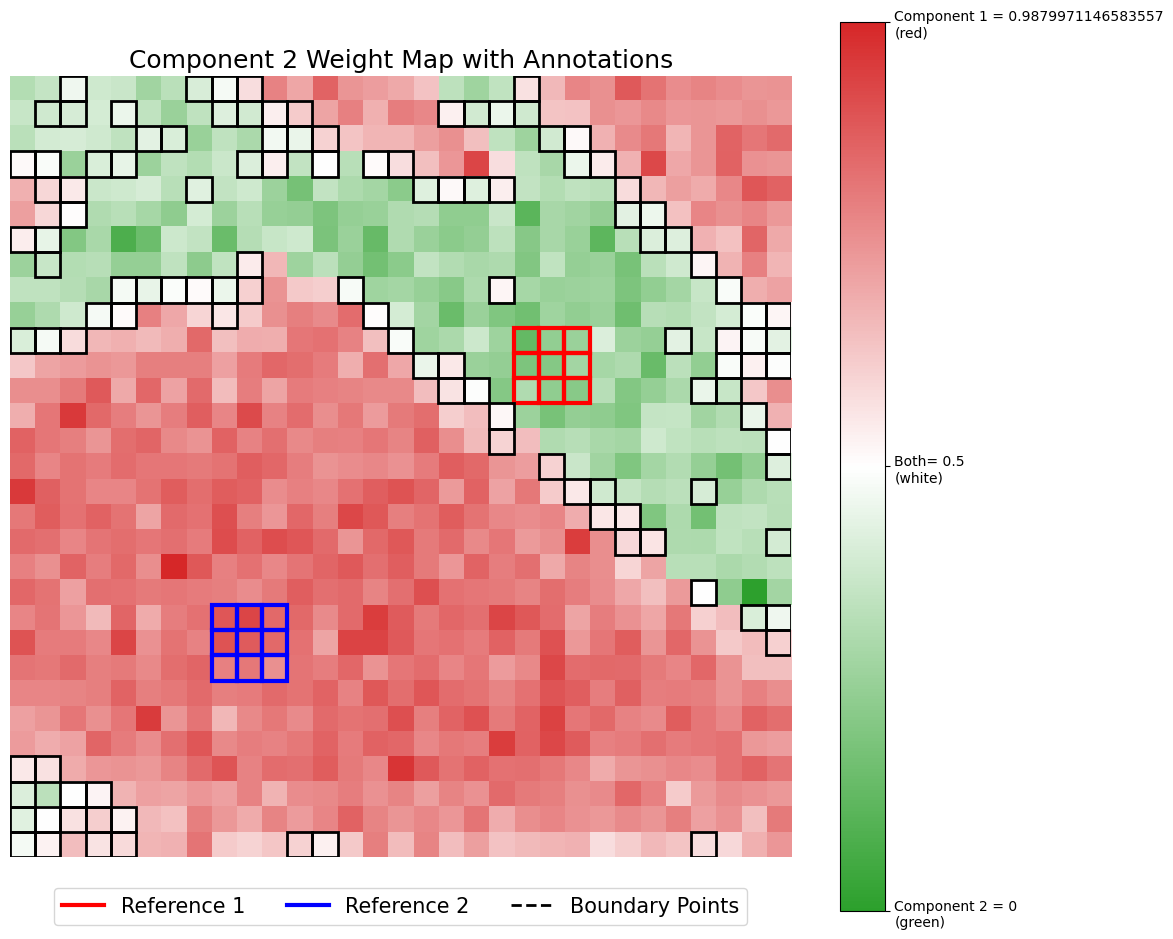

In [30]:
# anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

# _plot_cnmf(weights, coor_dict, loc, ref7_pos, ref8_pos, None)

plot_weight_map_cnmf(weights, loc, None, ref7_pos, ref8_pos, 0, boundary_locs)
plot_weight_map_cnmf(weights, loc, None, ref7_pos, ref8_pos, 1, boundary_locs)

### 1.4.2 Reference components based on model performance comparison

In [ ]:
optimize_results= optimize_paired_components(R6, path, grid, x_range_r1, y_range_r1, x_range_r2, y_range_r2, 2, 2, 3)

In [21]:
np.shape(optimize_results['components'][0])

(2, 22500)

> The optimization here is to select the "best" paired regions (component pairs), evaluate the model performance (such as MSE and R2) for each pair,
    and return the best results.

In [20]:
optimize_results.head(1)


R1_x_range R1_y_range R2_x_range R2_y_range       mse        r2  \
0   (30, 32)   (25, 27)   (40, 42)   (12, 14)  0.000015  0.671728   

                                          components  \
0  [[0.5803921568627451, 0.5529411764705883, 0.58...   

                                             weights  
0  [[[0.30449522, 0.56954694]], [[0.43287674, 0.5...

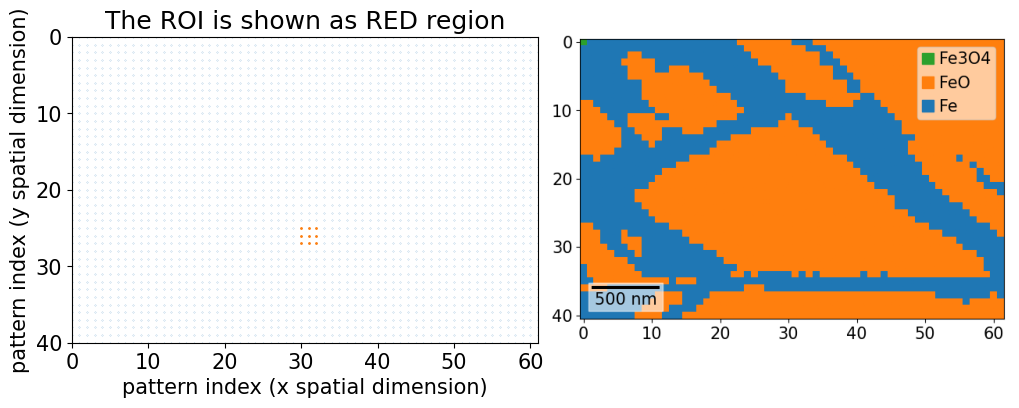

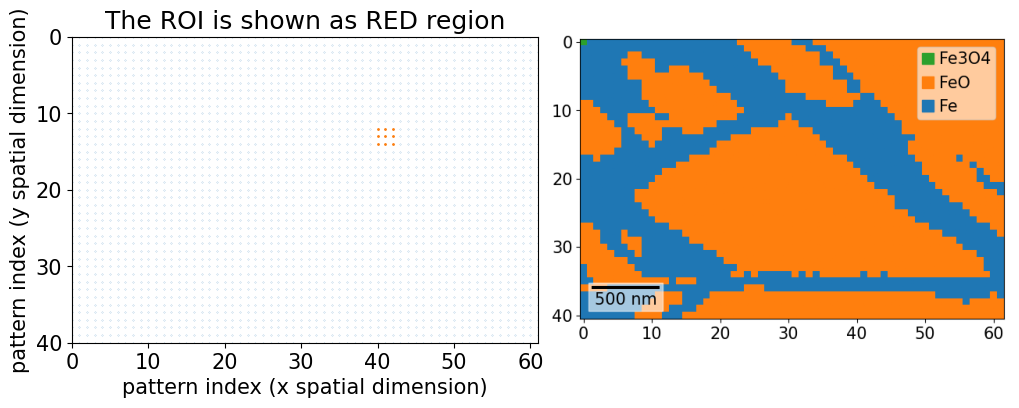

In [20]:
# set components
x_range_1 = (30,32)
y_range_1 = (25,27)
R1, ref1_pos = set_component(x_range_1, y_range_1, path, grid)


x_range_2 = (40,42)
y_range_2 = (12,14)
R2, ref2_pos = set_component(x_range_2, y_range_2, path, grid)

In [21]:
components = get_components(R1, R2)
# run cNMF
weights,mse,r_square = run_cNMF(R6, components)

gmm_model3, cluster_coords_cnmf1, cluster_labels_cnmf1, optimal_n, silhouette = gmm_clustering(weights, loc_relative, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf1 = {}
for label, coords_list in cluster_coords_cnmf1.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf1[coord_tuple] = label
anomalies_cluster_cnmf_weights, anomalies_cluster_cnmf_coords = detect_anomalies_cnmf(weights, coord_to_label_cnmf1, loc_relative)
centers_c, covs_c, variations_c = calculate_cluster_metrics(gmm_model3, cluster_labels_cnmf1, weights)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 1.17 ms

[########################################] | 100% Completed | 108.66 ms
[########################################] | 100% Completed | 108.09 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 106.70 ms
[########################################] | 100% Completed | 132.47 ms
[########################################] | 100% Completed | 106.71 ms
[########################################] | 100% Completed | 111.26 ms
[########################################] | 100% Completed | 113.80 ms
[########################################] | 100% Completed | 118.90 ms
[########################################] | 100% Completed | 118.71 ms
[########################################] | 100% Completed | 115.14 ms
[########################################] | 100% Completed | 112.87 ms
[########################################] | 100% Completed | 114.81 ms
[########################################] | 100% Completed | 114.12 ms
[#########################

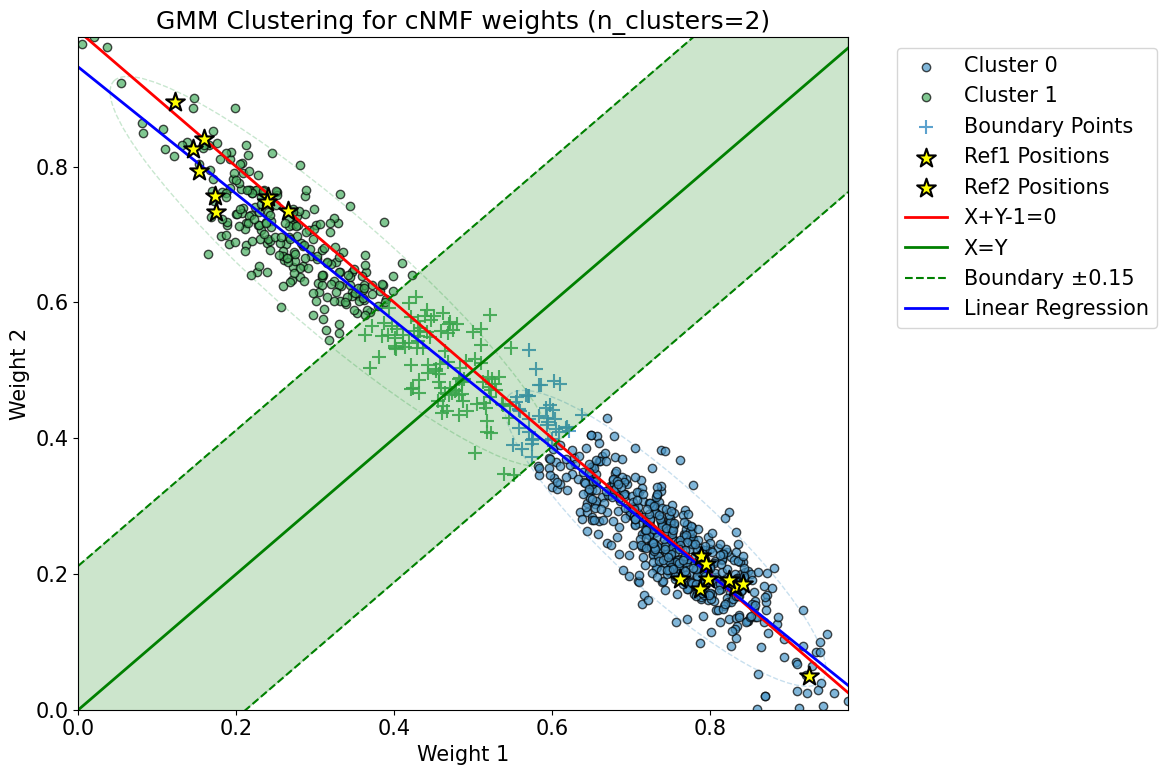

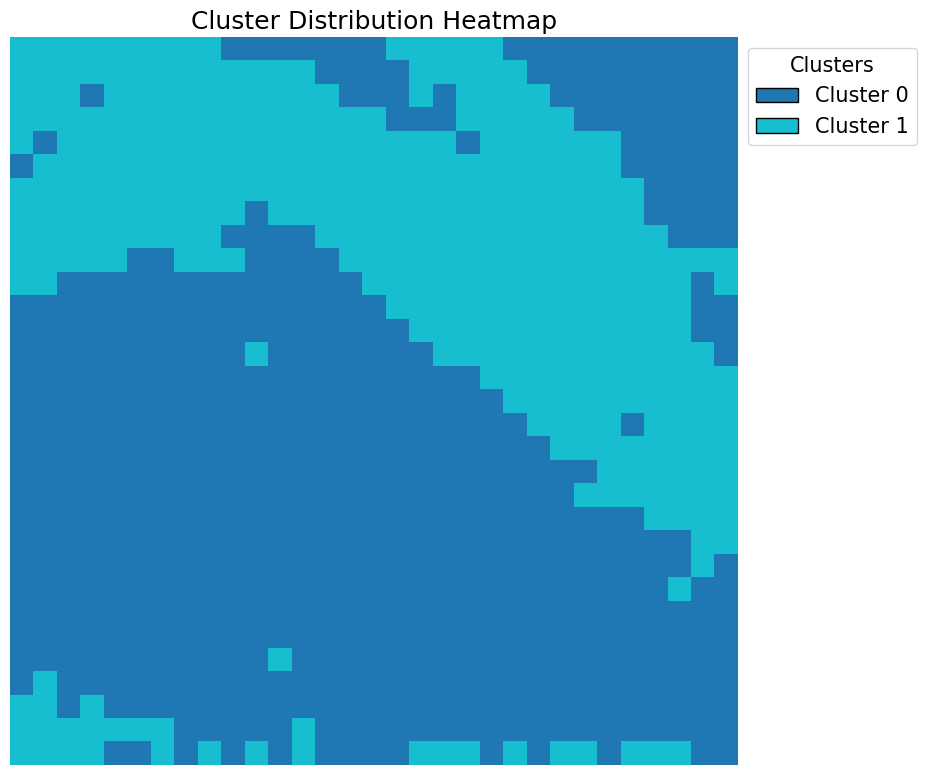

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.587783
             NMI 0.479402
     homogeneity 0.494725
    completeness 0.465000
       v_measure 0.479402
   user_accuracy 0.884495
optimal_accuracy 0.884495

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      596          FeO               FeO
       1      365           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        571        86
True: Fe          25       279


In [22]:
boundary_mask2, boundary_scores2, boundary_locs2, boundary_labels2, slope2, intercept2 = plot_cnmf_scatter_with_boundary(weights, loc, cluster_labels_cnmf1, optimal_n, ref1_pos, ref2_pos, d=0.15)

plot_cluster_heatmap(cluster_coords_cnmf1,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict_roi, coord_to_label_cnmf1, name_map, cluster_name_map, True)

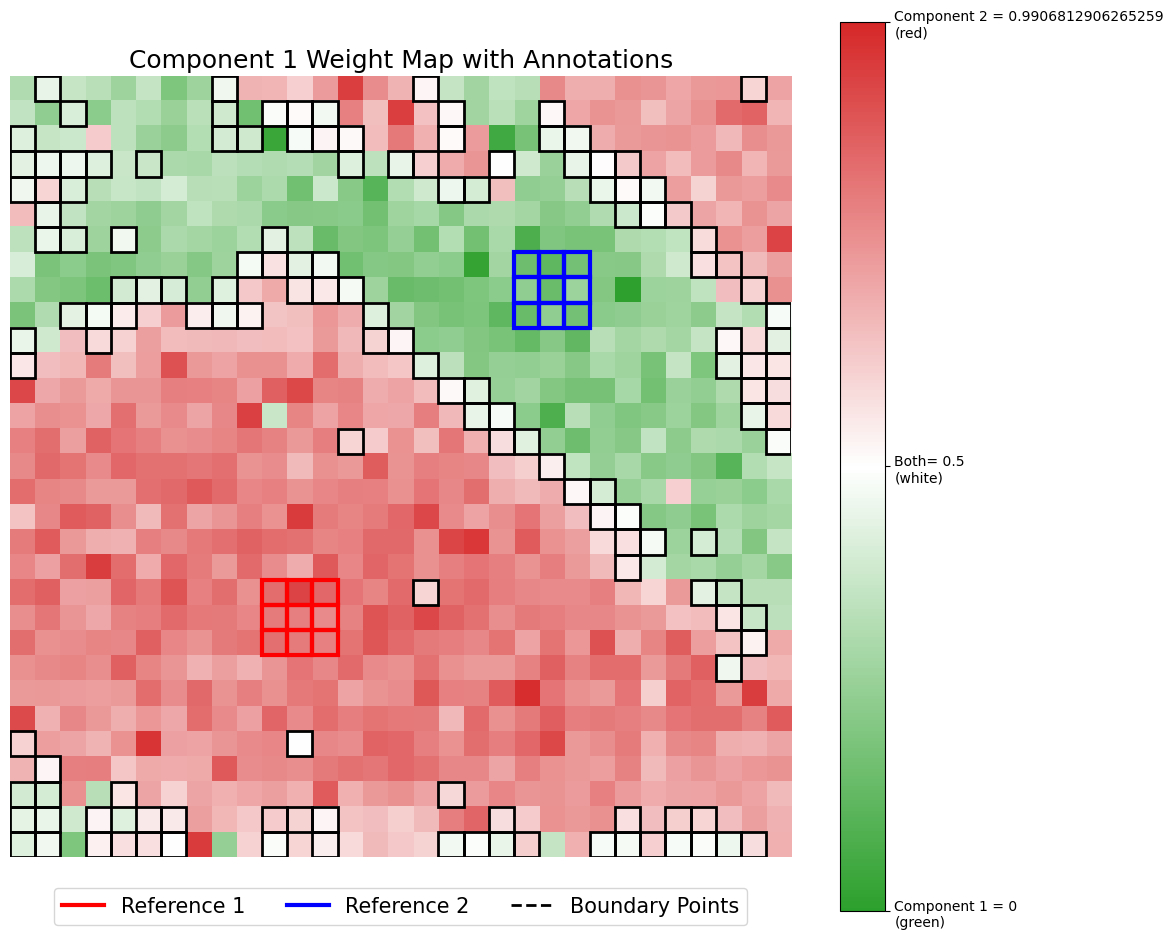

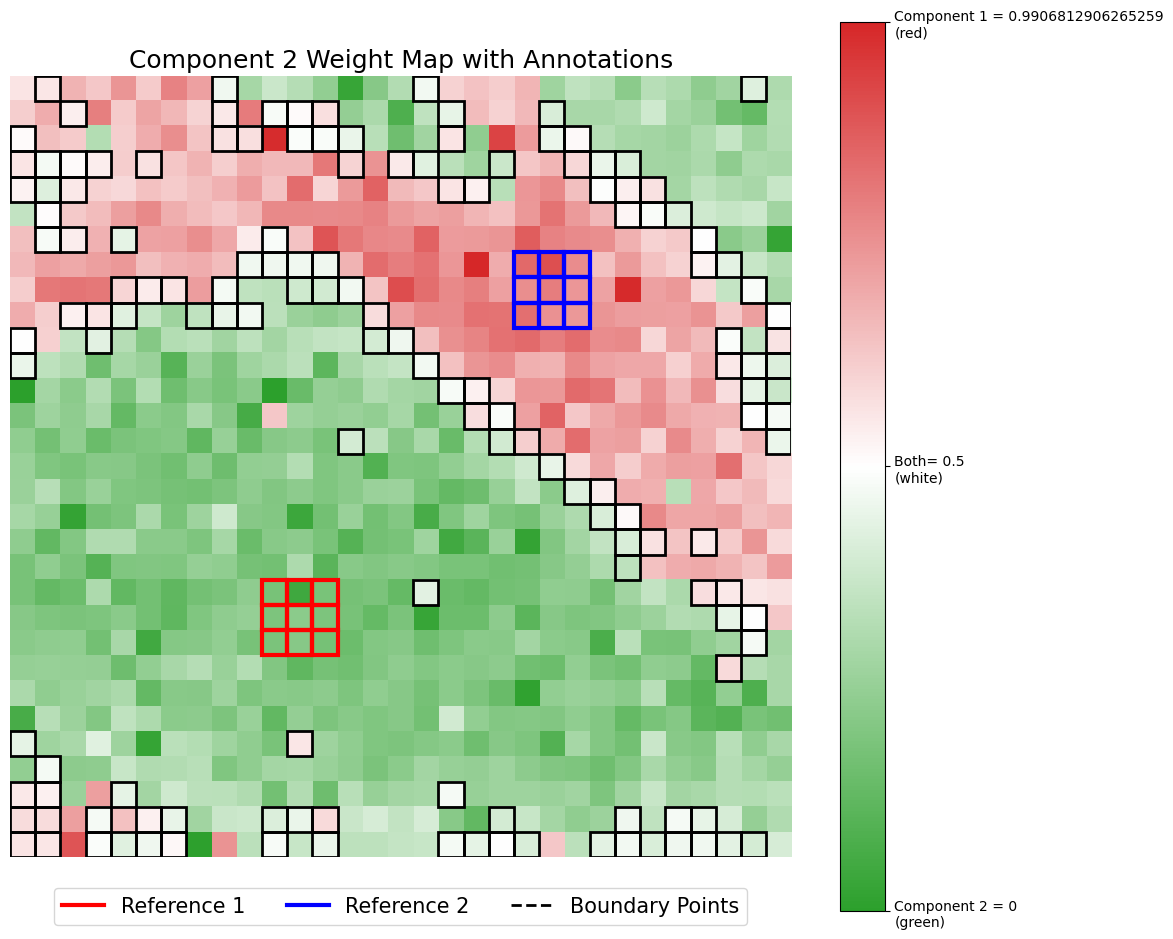

In [23]:
# anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

# _plot_cnmf(weights, coor_dict, loc)
# _plot_cnmf(weights, coor_dict, loc, ref1_pos, ref2_pos, None)

plot_weight_map_cnmf(weights, loc, None, ref1_pos, ref2_pos, 0, boundary_locs2)
plot_weight_map_cnmf(weights, loc, None, ref1_pos, ref2_pos, 1, boundary_locs2)

### 1.3 EDS combined? （only content of elements）

### 1.3.1 cNMF

In [40]:
components = get_components(R7, R8)

# stacked the pixel values with element values
eds_r1 = get_eds_average(x_range_7,y_range_7,s_edax)
eds_r2 = get_eds_average(x_range_8,y_range_8,s_edax)

eds_r1 = normalize_sum(eds_r1)
eds_r2 = normalize_sum(eds_r2)
eds = np.stack((eds_r1, eds_r2))

eds_mixed = np.hstack((components,eds))

The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 113.94 ms
[########################################] | 100% Completed | 117.79 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 141.71 ms
[########################################] | 100% Completed | 116.24 ms


In [41]:
weights,mse,r_square = run_cNMF_mixeds(R6, eds_mixed, loc, s_edax)

gmm_model_mixed, cluster_coords_cnmf2, cluster_labels_cnmf2, optimal_n, silhouette = gmm_clustering(weights, loc, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf2 = {}
for label, coords_list in cluster_coords_cnmf2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf2[coord_tuple] = label
# anomalies_cluster_cnmf_weights2, anomalies_cluster_cnmf_coords2 = detect_anomalies_cnmf(weights, coord_to_label_cnmf2, loc_relative)
centers_c2, covs_c2, variations_c2 = calculate_cluster_metrics(gmm_model_mixed, cluster_labels_cnmf2, weights)

[########################################] | 100% Completed | 112.72 ms
[########################################] | 100% Completed | 116.23 ms
[########################################] | 100% Completed | 119.38 ms
[########################################] | 100% Completed | 111.30 ms
[########################################] | 100% Completed | 113.39 ms
[########################################] | 100% Completed | 116.30 ms
[########################################] | 100% Completed | 117.07 ms
[########################################] | 100% Completed | 113.02 ms
[########################################] | 100% Completed | 116.57 ms
[########################################] | 100% Completed | 115.54 ms
[########################################] | 100% Completed | 114.21 ms
[########################################] | 100% Completed | 112.24 ms
[########################################] | 100% Completed | 113.79 ms
[########################################] | 100% Completed | 11

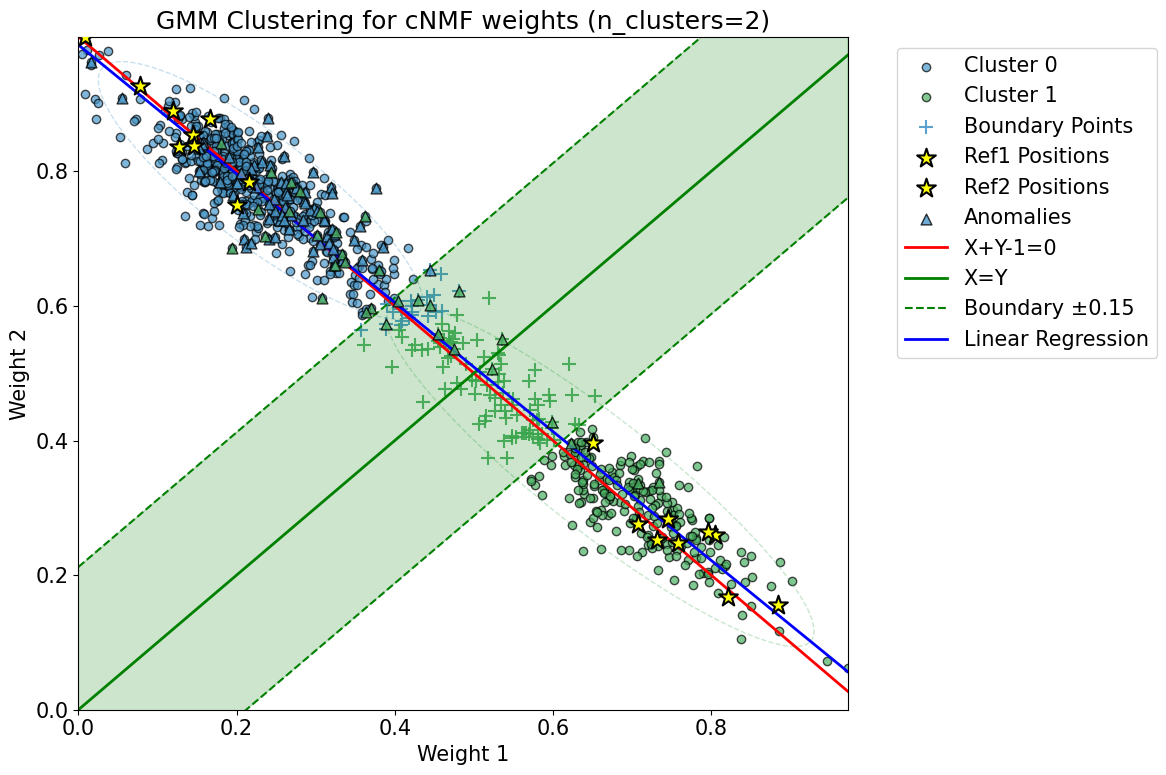

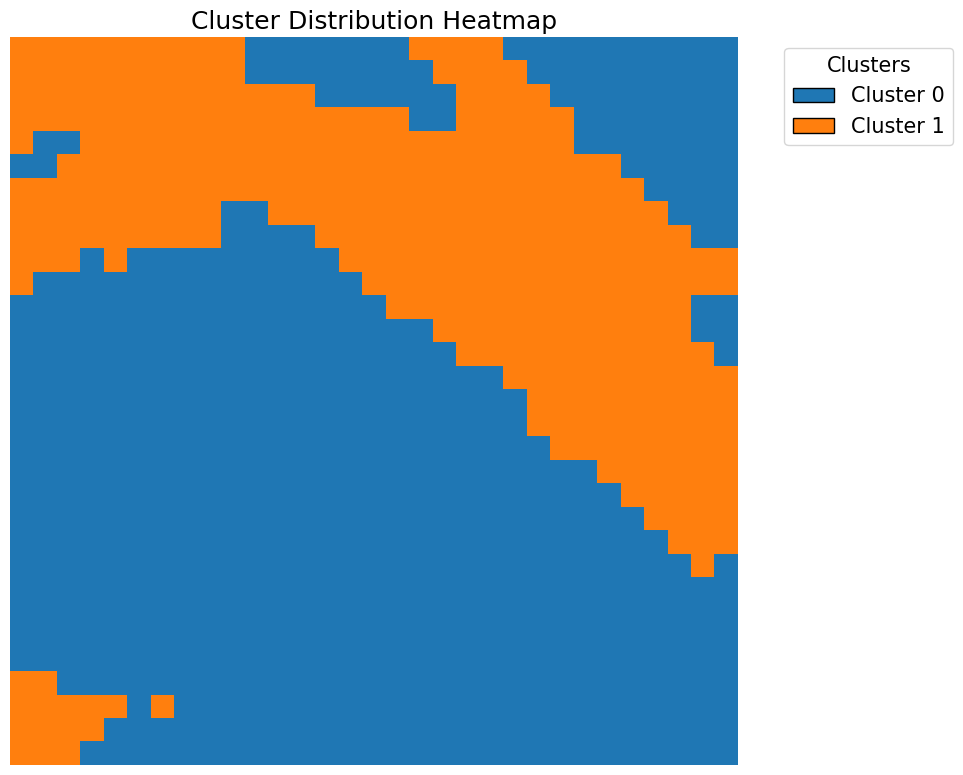

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
          Metric    Value
             ARI 0.602143
             NMI 0.471298
     homogeneity 0.479545
    completeness 0.463329
       v_measure 0.471298
   user_accuracy 0.889698
optimal_accuracy 0.889698

Optimal Cluster-to-Phase Mapping:
------------------------------------------------------------
 cluster  Samples User mapping Algorithm mapping
       0      627          FeO               FeO
       1      334           Fe                Fe

Confusion Matrix (After Mapping):
------------------------------------------------------------
           Pred: FeO  Pred: Fe
True: FeO        589        68
True: Fe          38       266


In [42]:
boundary_mask3, boundary_scores3, boundary_locs3, boundary_labels3, slope3, intercept3 = plot_cnmf_scatter_with_boundary(weights, loc, cluster_labels_cnmf2, optimal_n, ref7_pos, ref8_pos, anomalies_coord_label_dict2, d=0.15)
plot_cluster_heatmap(cluster_coords_cnmf2,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
evaluate_results = evaluate_clustering_metrics(coor_dict_roi, coord_to_label_cnmf2, name_map, cluster_name_map, True)

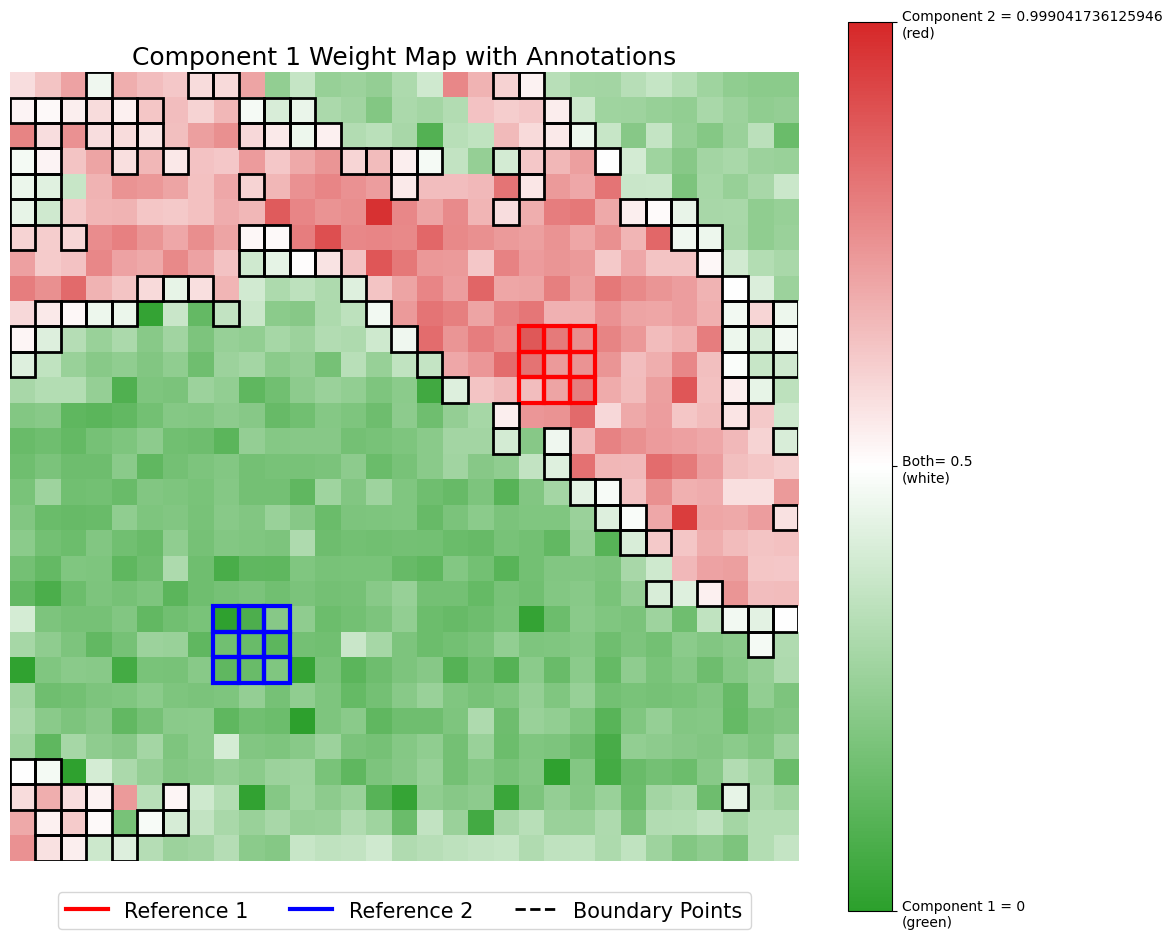

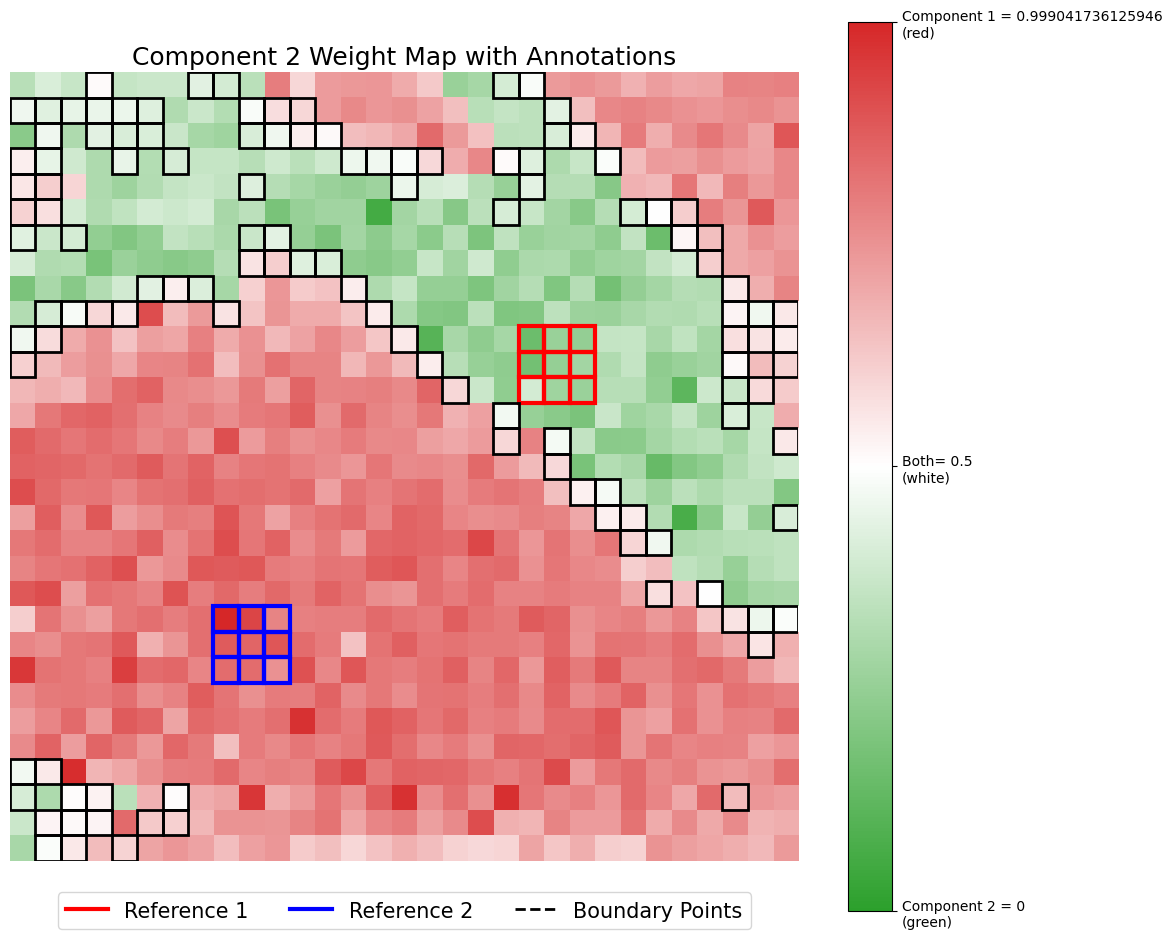

In [43]:
# anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

# _plot_cnmf(weights, coor_dict, loc)
# _plot_cnmf(weights, coor_dict, loc, ref7_pos, ref8_pos, None)

plot_weight_map_cnmf(weights, loc, None, ref7_pos, ref8_pos, 0, boundary_locs3)
plot_weight_map_cnmf(weights, loc, None, ref7_pos, ref8_pos, 1, boundary_locs3)

> ### Some Thinking about what else information we can obtain from just kikuchi? (diffraction of crystalline planes)
- Standard EBSD
    1. Phase identification
    2. crystal orientation
    3. misorientation/ grain boundaries
    4. Defects/ Strain and Stress/ Dislocation(subtle shifts of kikuchi bands)/ Local lattice or composition change ---HR-EBSD


- Solutions
    1. DR/ Latent space representation/ Clustering - Phase (Now) + (to do)Misorientation (Minor)
    2. 
    3. 
    